In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression

from matplotlib_venn import venn2
from tqdm import tqdm

from imblearn.over_sampling import SMOTENC




In [2]:
import src.features as features
import src.model_selection as model_selection 
import src.functions as functions
import src.datasets as datasets 

# import custom functions
from src.functions import plot_correlations, plot_mutual_info, hello
from src.datasets import xy_train, xy_train_test, data_original, data_50000, data_balanced

In [ ]:
data = pd.read_csv("./data/AIDS_Classification.csv")
data.head(1)

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0


In [4]:
def data_time730(dataset = data_original(), drop_censored = False):
    """ 
    replaces feature "time" with 
    - time730: counts the days over the 2 years time target 
    - time_censored: counts the censored days up to the 2 years time target
    """

    if "time" not in df.columns:
      print("Warning: the data does not have a feature 'time' to be replaced with time730.")
      return df

    # this shifted ReLU does the job:
    df["time730"] = np.maximum(0, df['time'] - 730)

    # censored patients: they quit the study before 2 years
    if not drop_censored:
      df["time_censored"] = np.maximum(0,730 - df['time'])

    df= df.drop(columns = ['time'])
    return df

## Settings

In [5]:
# default plt figuresize, smallish
plt.rcParams["figure.figsize"] = (6,3)

# Sprint 1

### 006 Dataset Structure

In [6]:
## number of rows and columns of the tabular data 
data.shape

(2139, 23)

In [7]:
## all data is integer except `wtkg`
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      2139 non-null   int64  
 1   trt       2139 non-null   int64  
 2   age       2139 non-null   int64  
 3   wtkg      2139 non-null   float64
 4   hemo      2139 non-null   int64  
 5   homo      2139 non-null   int64  
 6   drugs     2139 non-null   int64  
 7   karnof    2139 non-null   int64  
 8   oprior    2139 non-null   int64  
 9   z30       2139 non-null   int64  
 10  preanti   2139 non-null   int64  
 11  race      2139 non-null   int64  
 12  gender    2139 non-null   int64  
 13  str2      2139 non-null   int64  
 14  strat     2139 non-null   int64  
 15  symptom   2139 non-null   int64  
 16  treat     2139 non-null   int64  
 17  offtrt    2139 non-null   int64  
 18  cd40      2139 non-null   int64  
 19  cd420     2139 non-null   int64  
 20  cd80      2139 non-null   int6

### 007 Missing values


In [8]:
#there is no missing value
missing = pd.DataFrame({
    "null": data.isnull().sum(), 
    "NaN": data.isna().sum()
})
missing

,null,NaN
time,0,0
trt,0,0
age,0,0
wtkg,0,0
hemo,0,0
homo,0,0
drugs,0,0
karnof,0,0
oprior,0,0
z30,0,0


### 008 Target is binary 

In [9]:
# The target variable 'infected' is binary with values 0 and 1
data['infected'].unique()

array([0, 1])

### 009 Class imbalance 
<a id='009'></a>


infected
0    1618
1     521
Name: count, dtype: int64
Proportion of infected: 24.36%


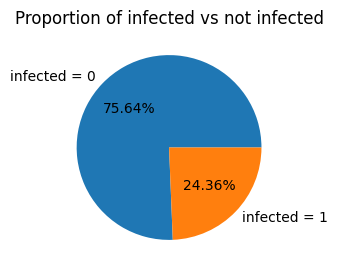

In [10]:
# The target class is moderately imbalanced : the positive class "infected" has the least numerosity 
count_infected_df = data['infected'].value_counts()
proportion_infected = count_infected_df[1]/(count_infected_df.sum())
print(count_infected_df)
print(f"Proportion of infected: {round(proportion_infected*100,2)}%")

plt.pie(count_infected_df, 
        labels = ["infected = 0", "infected = 1"], 
        colors = sns.color_palette(), 
        autopct='%.2f%%')
plt.title("Proportion of infected vs not infected")
plt.show()


### 010 Missing values strategy


There are no missing values in the dataset

#### 010 - the case of zero cd40 

We saw that there are no Null values in the data. However, for numerical features, missing values may have been recordeds as "zeros". There are 9 numerical features, two multiclass categorical features and 12 binary features (including the target). 

In [11]:
continuous_variables = "time age wtkg karnof preanti cd40 cd420 cd80 cd820".split()
data[continuous_variables].describe()

,time,age,wtkg,karnof,preanti,cd40,cd420,cd80,cd820
count,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000
mean,879.098177,35.248247,75.125311,95.446470,379.175783,350.501169,371.307153,986.627396,935.369799
std,292.274324,8.709026,13.263164,5.900985,468.657526,118.573863,144.634909,480.197750,444.976051
min,14.000000,12.000000,31.000000,70.000000,0.000000,0.000000,49.000000,40.000000,124.000000
25%,727.000000,29.000000,66.679200,90.000000,0.000000,263.500000,269.000000,654.000000,631.500000
50%,997.000000,34.000000,74.390400,100.000000,142.000000,340.000000,353.000000,893.000000,865.000000
75%,1091.000000,40.000000,82.555200,100.000000,739.500000,423.000000,460.000000,1207.000000,1146.500000
max,1231.000000,70.000000,159.939360,100.000000,2851.000000,1199.000000,1119.000000,5011.000000,6035.000000


The  minimum value for 'preanti' is 0, but this is normal, since it corresponds to the patients that started antiretroviral treatment contextually with this study. The minimum value for `cd40' may actually be 0, although this is unlikely since it is the number of cd4 cells per mm3 blood, and the average in the dataset is 350. Some inspection is required. 

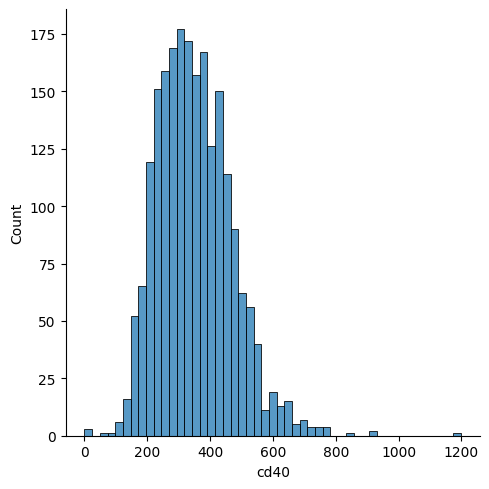

In [12]:
sns.displot(data= data, x= 'cd40')

In [13]:
data_zero_cd40 = data[data['cd40']==0]
data_zero_cd40

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
216,1027,1,45,67.1000,0,1,0,100,0,1,...,1,3,0,1,0,0,359,468,659,0
217,985,1,60,51.6000,0,0,0,100,0,1,...,1,3,0,1,1,0,523,1087,1727,0
723,1124,1,30,81.1944,0,1,1,100,0,0,...,0,1,0,1,1,0,566,998,1078,0


There are three patients with zero cd4 count. 

In [14]:
data[data['cd40']<120]

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
216,1027,1,45,67.1000,0,1,0,100,0,1,...,1,3,0,1,0,0,359,468,659,0
217,985,1,60,51.6000,0,0,0,100,0,1,...,1,3,0,1,1,0,523,1087,1727,0
285,1089,1,48,91.1736,0,1,0,100,0,1,...,1,3,0,1,0,84,541,706,1516,0
358,1022,0,34,79.6000,0,1,0,100,0,0,...,0,1,1,0,1,103,237,1084,1313,0
723,1124,1,30,81.1944,0,1,1,100,0,0,...,0,1,0,1,1,0,566,998,1078,0
1455,1029,1,43,101.0000,0,1,0,100,0,0,...,1,2,0,1,1,70,197,314,893,0
1667,1001,2,41,65.0916,1,0,0,100,1,0,...,1,3,0,1,1,99,80,105,173,0
1920,904,3,33,75.5000,0,1,0,90,0,0,...,0,1,0,1,1,112,348,291,541,1
1993,885,3,47,62.5968,0,0,0,90,0,1,...,1,3,0,1,1,110,80,230,140,1


Comparing with "low cd40" patients, we do not find enough evidence to infer that the null cd40 is to be treated as a "missing" value. We will consider this in the "outlier" analysis though.  

### 011 Numerical distributions

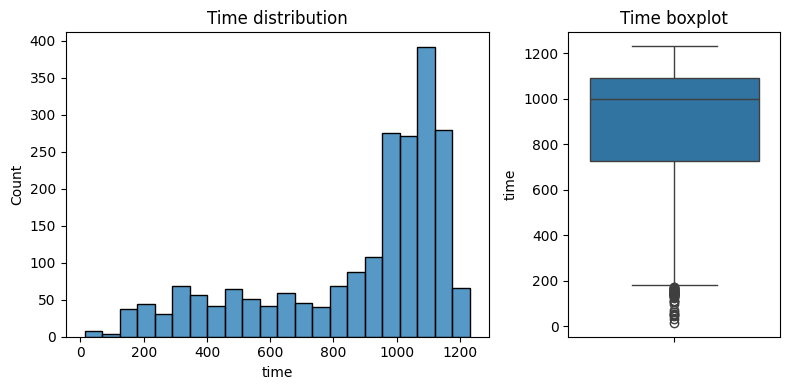

In [15]:

feature = "time"
fig,axes = plt.subplots(1,2,figsize = (8,4), sharey = False, gridspec_kw={'width_ratios': [2, 1]})
sns.histplot(data = data, x = feature, ax = axes[0])
sns.boxplot(data = data, y = feature, ax = axes[1])
axes[0].set_title(f'{feature.capitalize()} distribution')
axes[1].set_title(f'{feature.capitalize()} boxplot')
plt.tight_layout()
plt.show()

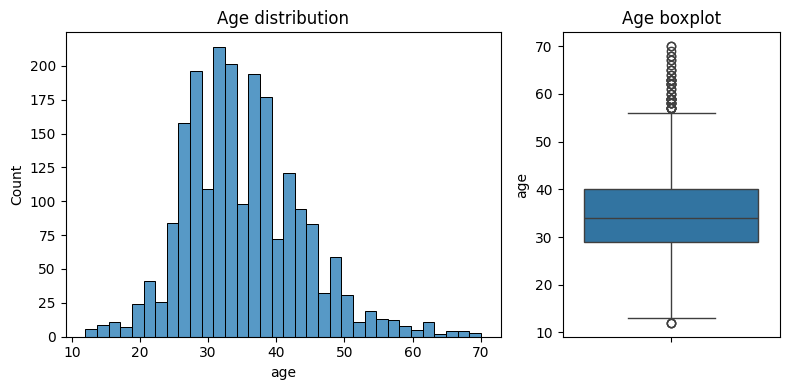

In [16]:
feature = "age"
fig,axes = plt.subplots(1,2,figsize = (8,4), sharey = False, gridspec_kw={'width_ratios': [2, 1]})
sns.histplot(data = data, x = feature, ax = axes[0])
sns.boxplot(data = data, y = feature, ax = axes[1])
axes[0].set_title(f'{feature.capitalize()} distribution')
axes[1].set_title(f'{feature.capitalize()} boxplot')
plt.tight_layout()
plt.show()

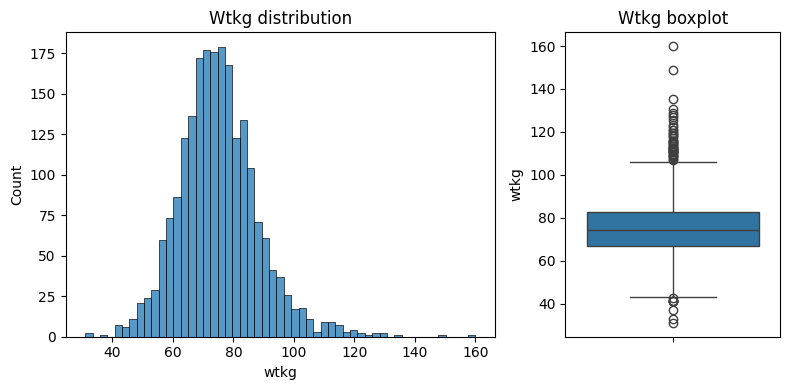

In [17]:
feature = "wtkg"
fig,axes = plt.subplots(1,2,figsize = (8,4), sharey = False, gridspec_kw={'width_ratios': [2, 1]})
sns.histplot(data = data, x = feature, ax = axes[0])
sns.boxplot(data = data, y = feature, ax = axes[1])
axes[0].set_title(f'{feature.capitalize()} distribution')
axes[1].set_title(f'{feature.capitalize()} boxplot')
plt.tight_layout()
plt.show()

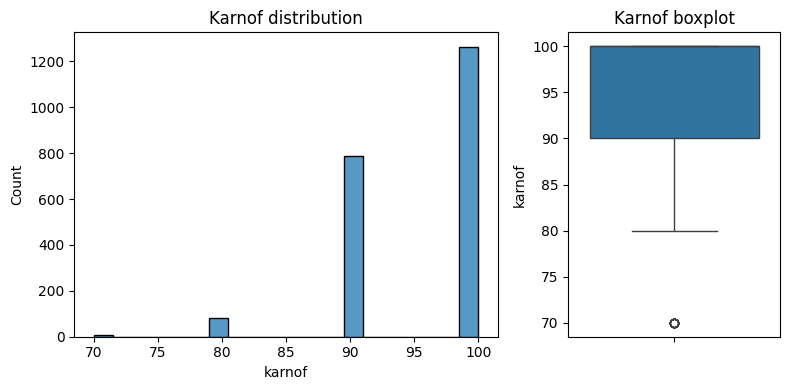

In [18]:
feature = "karnof"
fig,axes = plt.subplots(1,2,figsize = (8,4), sharey = False, gridspec_kw={'width_ratios': [2, 1]})
sns.histplot(data = data, x = feature, ax = axes[0])
sns.boxplot(data = data, y = feature, ax = axes[1])
axes[0].set_title(f'{feature.capitalize()} distribution')
axes[1].set_title(f'{feature.capitalize()} boxplot')
plt.tight_layout()
plt.show()

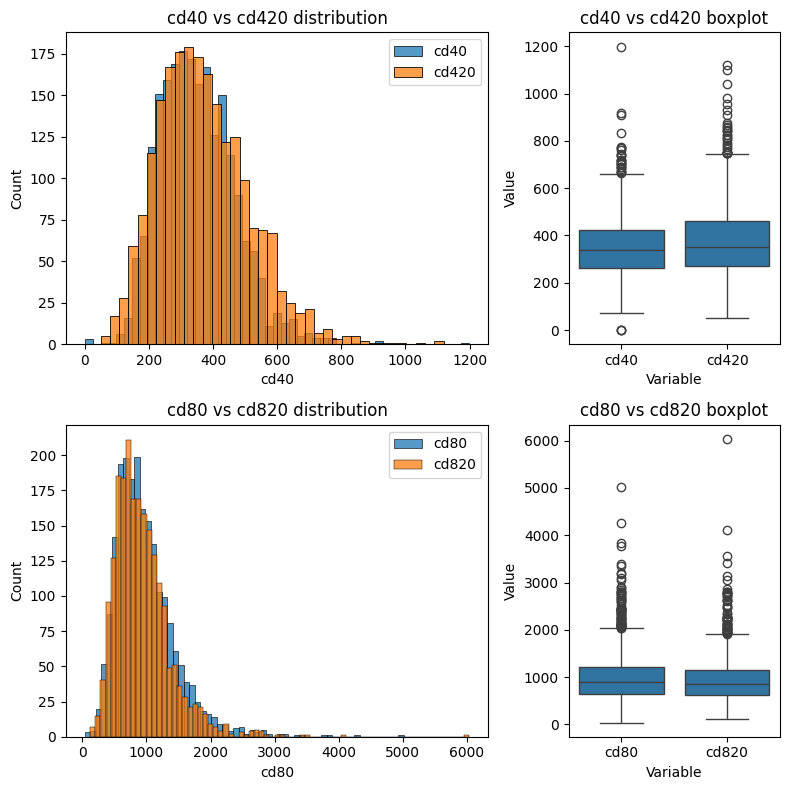

In [19]:
long_data_1 = pd.melt(data[['cd40', 'cd420']], var_name='Variable', value_name='Value')
long_data_2 = pd.melt(data[['cd80', 'cd820']], var_name='Variable', value_name='Value')
fig,axes = plt.subplots(2,2,figsize = (8,8), sharey = False, gridspec_kw={'width_ratios': [2, 1]})
sns.histplot(data = data, x = "cd40",label="cd40", ax = axes[0,0])
sns.histplot(data=data,x="cd420",label="cd420",ax=axes[0,0])
sns.histplot(data = data, x = "cd80",label="cd80", ax = axes[1,0])
sns.histplot(data=data,x="cd820",label="cd820",ax=axes[1,0])
sns.boxplot(data=long_data_1, x='Variable', y='Value', ax=axes[0, 1])
sns.boxplot(data=long_data_2, x='Variable', y='Value', ax=axes[1, 1])
axes[0, 0].set_title('cd40 vs cd420 distribution')
axes[1, 0].set_title('cd80 vs cd820 distribution')
axes[0, 1].set_title('cd40 vs cd420 boxplot')
axes[1,1].set_title("cd80 vs cd820 boxplot")
axes[0,0].legend()
axes[1,0].legend()
plt.tight_layout()
plt.show()

### 012 Categorical frequencies

trt: treatment indicator (0 = ZDV only; 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only)


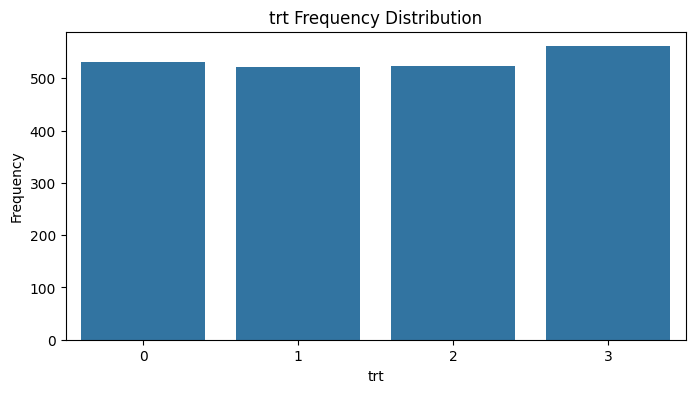

trt
3    561
0    532
2    524
1    522
Name: count, dtype: int64


In [20]:
print("\033[1mtrt: treatment indicator (0 = ZDV only; 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only)\033[0m")
frequency = data['trt'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='trt', data=data)
plt.title('trt Frequency Distribution')
plt.xlabel('trt')
plt.ylabel('Frequency')
plt.show()
print(frequency)

hemo: hemophilia (0=no, 1=yes)m


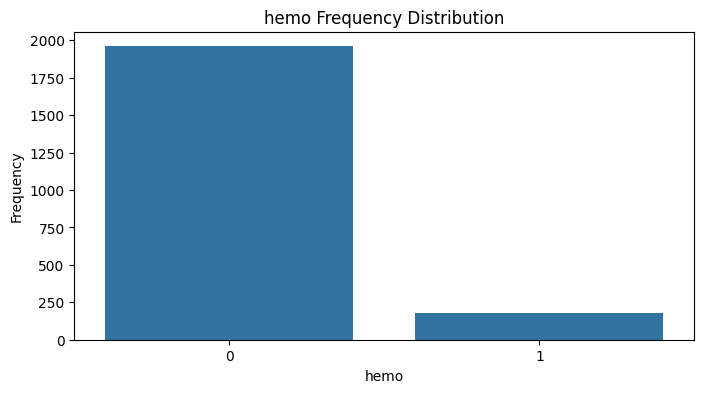

hemo
0    1959
1     180
Name: count, dtype: int64


In [21]:
print("\033[1mhemo: hemophilia (0=no, 1=yes)\033[om")
frequency = data['hemo'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='hemo', data=data)
plt.title('hemo Frequency Distribution')
plt.xlabel('hemo')
plt.ylabel('Frequency')
plt.show()
print(frequency)

homo: homosexual activity (0=no, 1=yes)


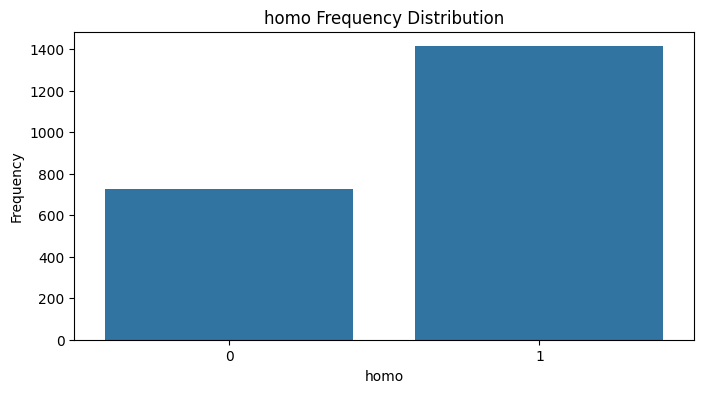

homo
1    1414
0     725
Name: count, dtype: int64


In [22]:
print("\033[1mhomo: homosexual activity (0=no, 1=yes)\033[0m")
frequency = data['homo'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='homo', data=data)
plt.title('homo Frequency Distribution')
plt.xlabel('homo')
plt.ylabel('Frequency')
plt.show()
print(frequency)

drugs: history of IV drug use (0=no, 1=yes)


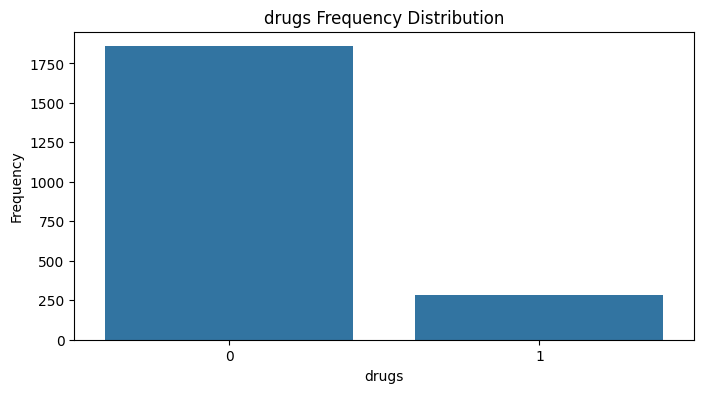

drugs
0    1858
1     281
Name: count, dtype: int64


In [23]:
print("\033[1mdrugs: history of IV drug use (0=no, 1=yes)\033[0m")
frequency = data['drugs'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='drugs', data=data)
plt.title('drugs Frequency Distribution')
plt.xlabel('drugs')
plt.ylabel('Frequency')
plt.show()
print(frequency)

oprior: Non-ZDV antiretroviral therapy pre-175(0=no,1=yes)


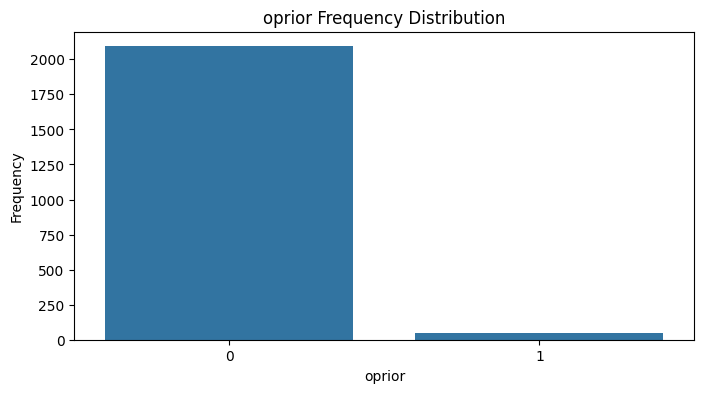

oprior
0    2092
1      47
Name: count, dtype: int64


In [24]:
print("\033[1moprior: Non-ZDV antiretroviral therapy pre-175(0=no,1=yes)\033[0m")
frequency = data['oprior'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='oprior', data=data)
plt.title('oprior Frequency Distribution')
plt.xlabel('oprior')
plt.ylabel('Frequency')
plt.show()
print(frequency)

z30: ZDV in the 30 days prior to 175 (0=no, 1=yes)


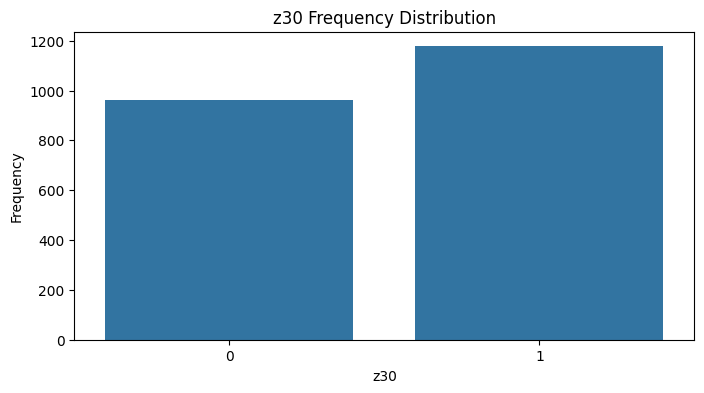

z30
1    1177
0     962
Name: count, dtype: int64


In [25]:
print("\033[1mz30: ZDV in the 30 days prior to 175 (0=no, 1=yes)\033[0m")
frequency = data['z30'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='z30', data=data)
plt.title('z30 Frequency Distribution')
plt.xlabel('z30')
plt.ylabel('Frequency')
plt.show()
print(frequency)

str2: antiretroviral history (0=naive, 1=experienced)


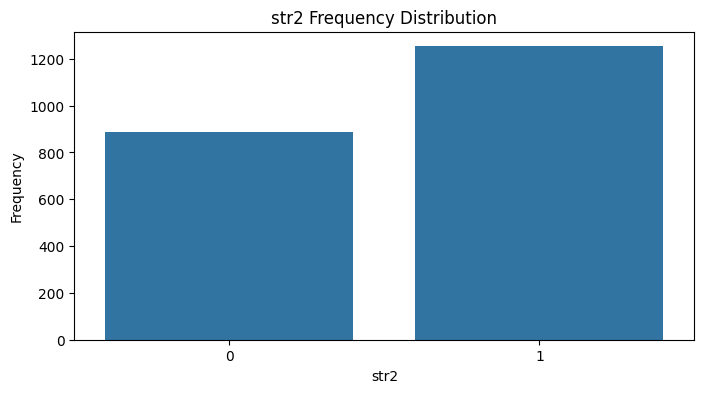

str2
1    1253
0     886
Name: count, dtype: int64


In [26]:
print("\033[1mstr2: antiretroviral history (0=naive, 1=experienced)\033[0m")
frequency = data['str2'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='str2', data=data)
plt.title('str2 Frequency Distribution')
plt.xlabel('str2')
plt.ylabel('Frequency')
plt.show()
print(frequency)

strat: antiretroviral history stratification (1='Antiretroviral Naive',2='> 1 but <= 52 weeks of prior antiretroviral therapy',3='> 52 weeks)


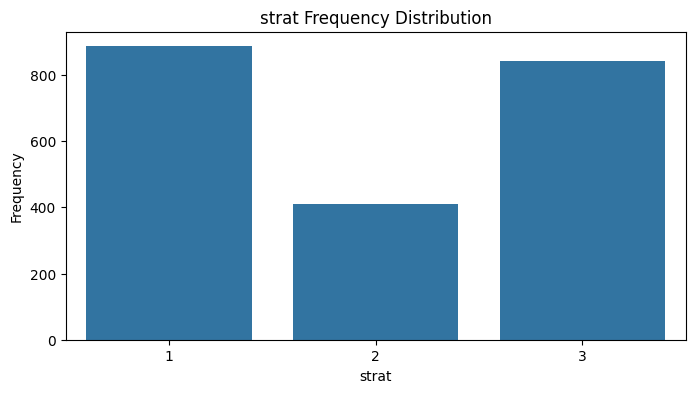

strat
1    886
3    843
2    410
Name: count, dtype: int64


In [27]:
print("\033[1mstrat: antiretroviral history stratification (1='Antiretroviral Naive',2='> 1 but <= 52 weeks of prior antiretroviral therapy',3='> 52 weeks)\033[0m")
frequency = data['strat'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='strat', data=data)
plt.title('strat Frequency Distribution')
plt.xlabel('strat')
plt.ylabel('Frequency')
plt.show()
print(frequency)

symptom: symptomatic indicator (0=asymp, 1=symp)


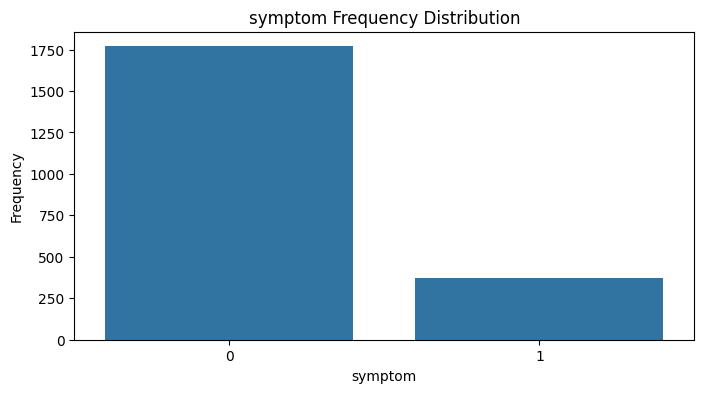

symptom
0    1769
1     370
Name: count, dtype: int64


In [28]:
print("\033[1msymptom: symptomatic indicator (0=asymp, 1=symp)\033[0m")
frequency = data['symptom'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='symptom', data=data)
plt.title('symptom Frequency Distribution')
plt.xlabel('symptom')
plt.ylabel('Frequency')
plt.show()
print(frequency)

treat: treatment indicator (0=ZDV only, 1=others)


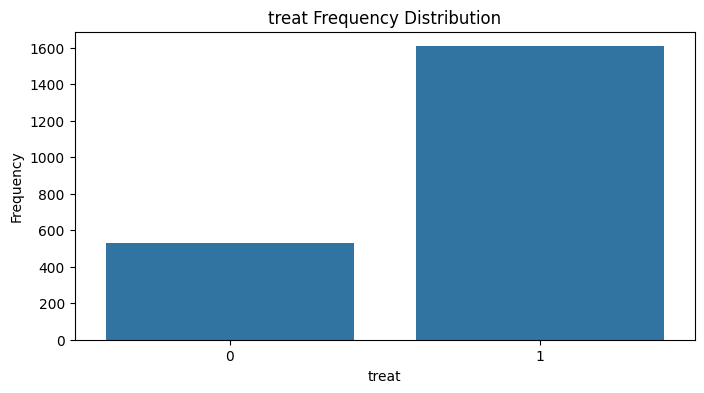

treat
1    1607
0     532
Name: count, dtype: int64


In [29]:
print("\033[1mtreat: treatment indicator (0=ZDV only, 1=others)\033[0m")
frequency = data['treat'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='treat', data=data)
plt.title('treat Frequency Distribution')
plt.xlabel('treat')
plt.ylabel('Frequency')
plt.show()
print(frequency)

offtrt: indicator of off-trt before 96+/-5 weeks (0=no,1=yes)


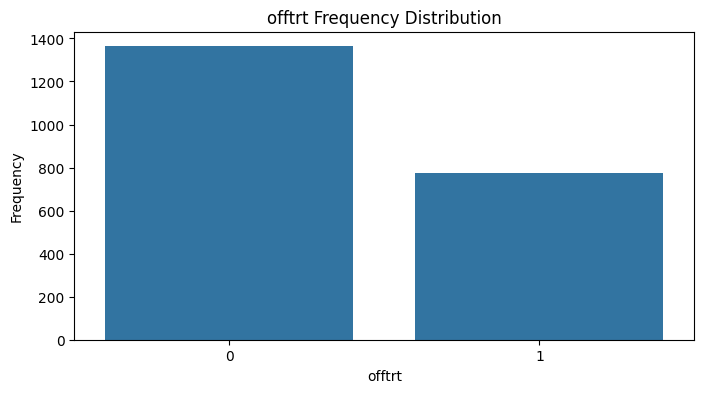

offtrt
0    1363
1     776
Name: count, dtype: int64


In [30]:
print("\033[1mofftrt: indicator of off-trt before 96+/-5 weeks (0=no,1=yes)\033[0m")
frequency = data['offtrt'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='offtrt', data=data)
plt.title('offtrt Frequency Distribution')
plt.xlabel('offtrt')
plt.ylabel('Frequency')
plt.show()
print(frequency)

infected: is infected with AIDS (0=No, 1=Yes)


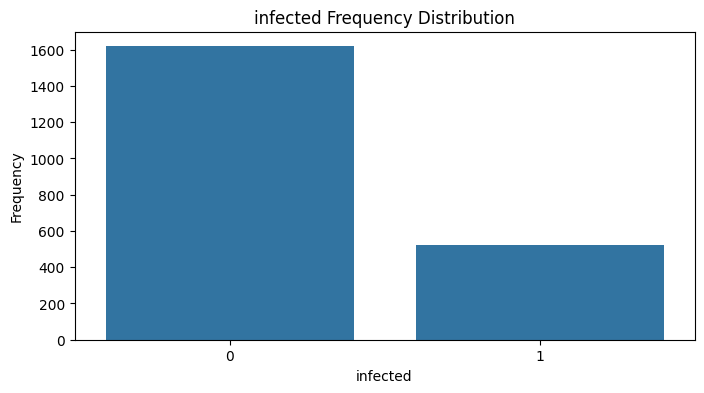

infected
0    1618
1     521
Name: count, dtype: int64


In [31]:
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
frequency = data['infected'].value_counts()
plt.figure(figsize=(8,4))
sns.countplot(x='infected', data=data)
plt.title('infected Frequency Distribution')
plt.xlabel('infected')
plt.ylabel('Frequency')
plt.show()
print(frequency)

### 013 Temporal analysis



There is no truly timestamped data so we cannot analyze time series for temporal patterns. 
- We do have a "time" variable though, that measures the total time a patient followed the treatment, from start to failure or censoring. 
- We also have the "preanti" variable that measures the time spent in antiretroviral therapy before the beginning of this study. 

In some sense, we can see "preanti" as a time variable that looks into the past, while "time" looks into the future.

Moreover we have the lab variables which were taken at different times in the patient treatment
- cd40 and cd80 are the cell counts per mm3 taken at the beginning of treatment
- cd420 adn cd820 are the cell counts per mm2 taken after 20+-5 weeks of treatment

#### 013-a Preanti and time vs target

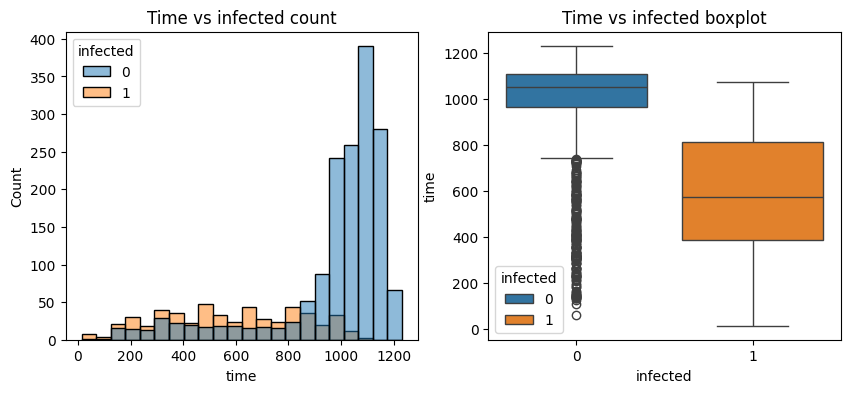

In [32]:
# Plot time vs infected

fig,axes = plt.subplots(1,2,figsize = (10,4), sharey = False)

sns.histplot(data = data, x= "time", hue = "infected", ax = axes[0])
sns.boxplot(data = data, x="infected", y = "time", hue = "infected", orient = "v", ax = axes[1])

axes[0].set_title('Time vs infected count')
axes[1].set_title('Time vs infected boxplot')
plt.show()

Conclusion: patients with time > 3 years thend not to be infected.

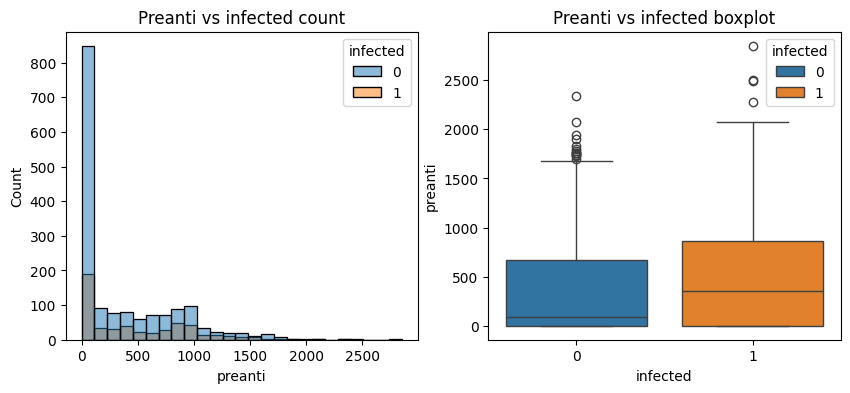

In [33]:
# Plot preanti vs infected

fig,axes = plt.subplots(1,2,figsize = (10,4), sharey = False)

sns.histplot(data = data, x= "preanti", hue = "infected", ax = axes[0])
sns.boxplot(data = data, x="infected", y = "preanti", hue = "infected", orient = "v", ax = axes[1])

axes[0].set_title('Preanti vs infected count')
axes[1].set_title('Preanti vs infected boxplot')
plt.show()

Conclusion: when preanti > 0, the distribution of "preanti" is similar for infected and non-infected patients. When preanti = 0 the proportion of "not-infected" is higher

#### 013-b Lab variables before/after

The individual distribution plots of cd40, cd420, cd80 and cd820 were shown in section 011.

In [34]:
# prepare to plot lab variables vs infected
lab_variables = "cd40 cd420 cd80 cd820 infected".split()
data_tmp = data[lab_variables].copy()
data_tmp["cd420-cd40"] = data_tmp["cd420"]-data_tmp["cd40"]
data_tmp["cd820-cd80"] = data_tmp["cd820"]-data_tmp["cd80"]
data_tmp.head(2)

,cd40,cd420,cd80,cd820,infected,cd420-cd40,cd820-cd80
0,422,477,566,324,0,55,-242
1,162,218,392,564,1,56,172


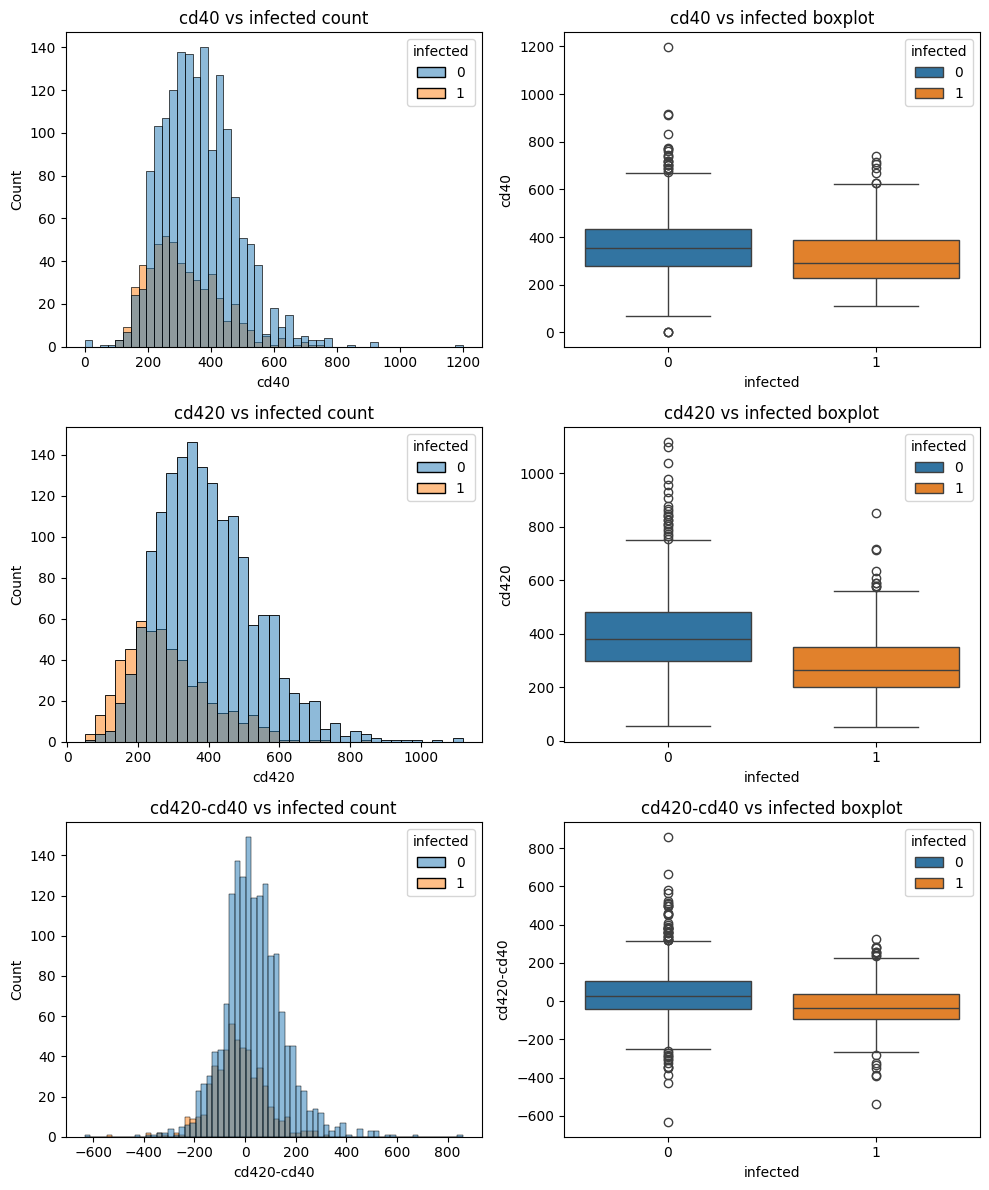

In [35]:
# Plot lab CD4 variables vs infected

fig,axes = plt.subplots(3,2,figsize = (10,12), sharey = False)
for i,variable in enumerate("cd40 cd420 cd420-cd40".split()):

    sns.histplot(data = data_tmp, x= variable, hue = "infected", ax = axes[i,0])
    sns.boxplot(data = data_tmp, x= "infected", y = variable, hue = "infected", orient = "v", ax = axes[i,1])

    axes[i,0].set_title(f'{variable} vs infected count')
    axes[i,1].set_title(f'{variable} vs infected boxplot')
plt.tight_layout()
plt.show()


Chart analysis: cd4 cell counts correlate negatively with being infected. The most notable difference is seen with "cd420" 

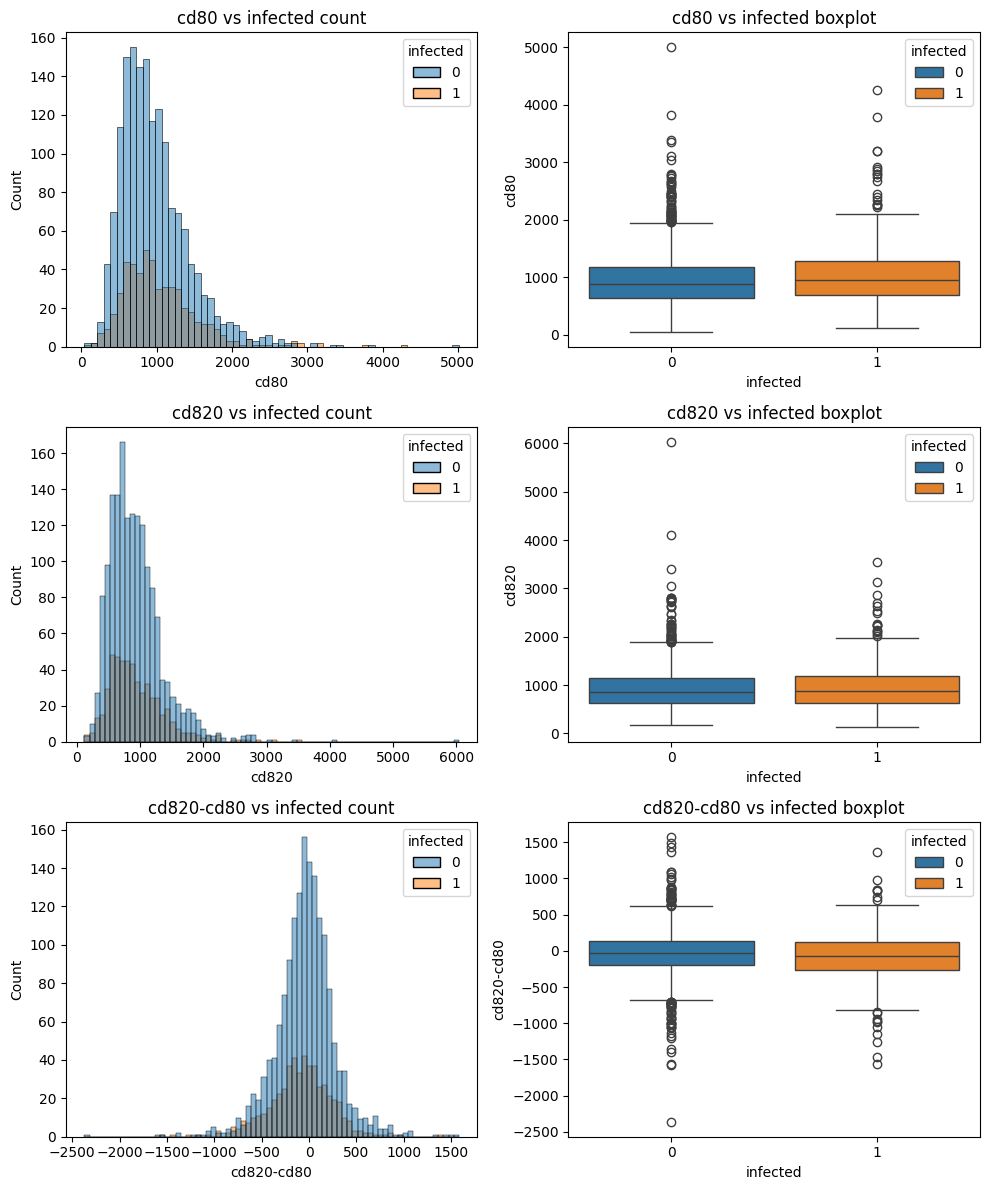

In [36]:
# Plot lab CD8 variables vs infected

fig,axes = plt.subplots(3,2,figsize = (10,12), sharey = False)
for i,variable in enumerate("cd80 cd820 cd820-cd80".split()):

    sns.histplot(data = data_tmp, x= variable, hue = "infected", ax = axes[i,0])
    sns.boxplot(data = data_tmp, x= "infected", y = variable, hue = "infected", orient = "v", ax = axes[i,1])

    axes[i,0].set_title(f'{variable} vs infected count')
    axes[i,1].set_title(f'{variable} vs infected boxplot')
plt.tight_layout()
plt.show()

Chart analysis: CD8 cell counts correlate poorly with being infected. 

### 014 Correlation with target

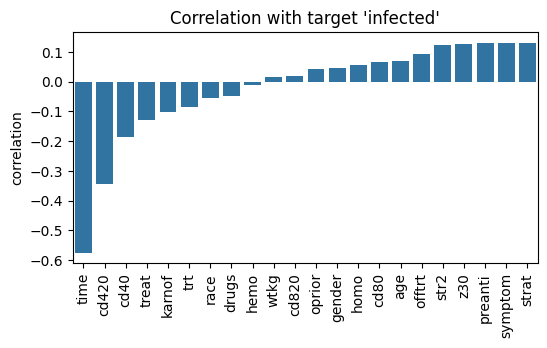

In [37]:
correlations = data.corr().loc['infected'].sort_values()
correlations.drop('infected',inplace = True)
sns.barplot(data = correlations)
plt.xticks(rotation=90)
plt.ylabel ("correlation")
plt.title("Correlation with target 'infected'")

plt.show()

### 015+020 Correlation matrix + Heatmap

In [38]:
data.corr()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
time,1.000000,0.101482,0.026544,0.009225,-0.017501,0.043430,-0.021856,0.094417,-0.016116,0.012898,...,0.010098,0.022033,-0.104611,0.153314,-0.475795,0.191436,0.350611,-0.017425,0.032480,-0.574989
trt,0.101482,1.000000,-0.001931,-0.031685,0.012329,0.025035,0.005712,-0.014573,-0.026805,-0.001656,...,-0.003003,-0.003508,-0.000765,0.775990,-0.043239,-0.012770,0.064448,-0.015665,-0.004595,-0.084360
age,0.026544,-0.001931,1.000000,0.132858,-0.231257,0.158917,0.077446,-0.100041,0.056161,0.061178,...,0.068230,0.089884,0.032814,0.001499,-0.057695,-0.040302,-0.044294,0.046874,0.037458,0.070384
wtkg,0.009225,-0.031685,0.132858,1.000000,-0.075791,0.155909,0.002343,0.034271,0.009607,-0.073841,...,-0.078885,-0.080458,0.003942,-0.040638,-0.003159,0.036401,0.020980,0.090075,0.085447,0.016205
hemo,-0.017501,0.012329,-0.231257,-0.075791,1.000000,-0.391307,-0.092957,0.068403,0.034978,0.111554,...,0.124983,0.141674,-0.076296,0.010786,0.005949,-0.022533,-0.065838,-0.037273,-0.058392,-0.011154
homo,0.043430,0.025035,0.158917,0.155909,-0.391307,1.000000,-0.206876,-0.042072,0.019743,-0.049760,...,-0.036700,-0.022608,0.118575,0.024407,-0.045151,0.000511,0.019915,0.086028,0.082284,0.054279
drugs,-0.021856,0.005712,0.077446,0.002343,-0.092957,-0.206876,1.000000,-0.084558,-0.029968,0.014961,...,0.001106,-0.011319,0.027052,0.022055,0.098031,-0.003360,0.013109,0.014900,0.025728,-0.049794
karnof,0.094417,-0.014573,-0.100041,0.034271,0.068403,-0.042072,-0.084558,1.000000,-0.057291,-0.074947,...,-0.085975,-0.055172,-0.107940,0.001379,-0.103251,0.077730,0.098463,-0.008567,-0.003981,-0.102944
oprior,-0.016116,-0.026805,0.056161,0.009607,0.034978,0.019743,-0.029968,-0.057291,1.000000,-0.037580,...,0.126040,0.134629,0.024199,-0.031801,0.019561,-0.059199,-0.109643,-0.019247,-0.036577,0.041251
z30,0.012898,-0.001656,0.061178,-0.073841,0.111554,-0.049760,0.014961,-0.074947,-0.037580,1.000000,...,0.903417,0.848624,0.020883,0.003776,-0.029318,-0.121282,-0.200149,0.029346,0.018454,0.125488


<Axes: >

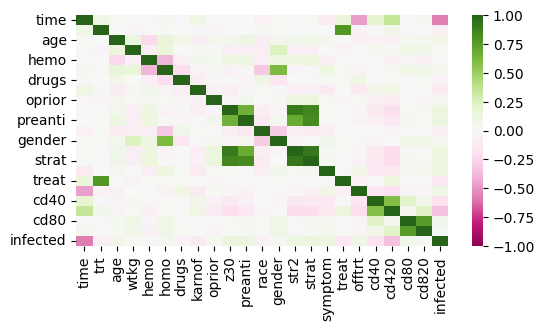

In [39]:
sns.heatmap(data.corr(),cmap="PiYG",vmax = 1, vmin = -1)

Analyis of correlation:
- z30, preanti, st2 and strat are positively correlated to each other (patient antiretroviral history);
- treat is correlated with trt (current treatment);
- gender, homo and -race are moderately correlated (personal info); 
- homo is moderately correlated with -hemo (moderately surprising);
- time is mildly positively correlated with cd40 and cd420, highly negatively correlated with offtrt and infected;
- infected is mostly correlated with time and cd420.


### 016 Simple Feature Engineering

#### 016-trt Dummy variables for treatment



- Treat is a categorical variable with values 0,1,2,3. 
- We replace it with dummy variables in preparation for logistic regression.

In [40]:
def simple_engineer_trt(dataset, drop = True):
    df = dataset.copy()
    df['trt0'] = (df['treat']==0).astype(int)
    df['trt1'] = (df['treat']==1).astype(int)
    df['trt2'] = (df['treat']==2).astype(int)
    if drop:
        df = df.drop(columns = ['trt', 'treat'])
    return df

#### 016-str Remove correlated variables pertaining to previous antiretroviral therapy

There are four highly correlated variables: 
- str2 is binary and equivalent to strat == 1
- z30 is binary and highly correlated with str2
- preanti = 0 is equivalent to strat == 1

We decide to keep only strat, which can be thought essentially both as a simplified version of preanti and as refinement of str2 and z30
- we do not make dummy variables for strat: we treat it as a numerical ordinal variable (with three values)


In [41]:
def simple_engineer_str(dataset, drop = True):
    df = dataset.copy()
    if drop:
        df = df.drop(columns = 'str2 z30 preanti'.split())
    return df

#### 016- Distinguish between time more or less than 2 years

We saw from the EDA that the records with time>800 days and time <800 days correlate very differently with respect to the target 'infected'. That is because the objective of the study was to follow patients for at least 2 years. If they ended the study before the 2 years target, chances are that they had some problem relevant to us. 

We may cut smoothly the two pieces of the distribution "time", but we'll keep it simple and cut abruptly

In [42]:
def simple_engineer_time(dataset, drop = True):
    df = dataset.copy()
    mask_time = (df['time']<730).astype(int)
    df['time<2y'] = df['time'] * mask_time 
    df['time>2y'] = df['time'] * (1-mask_time)
    if drop:
        df = df.drop(columns = ['time'])
    return df

#### 016-cd48  Engineer lab variables

#### 016-simple feature engineer altogether

Another pair of highly correlated variables is cd80 vs cd820. None of them is directly correlated with the target, but cd80 may tell us the state of infection at the beginning of treatment, so it may have interactions with other variables or replace str2 which we dropped. We will keep cd80 and remove cd820.

In [43]:
def simple_engineer(dataset, drop = True):
    df = dataset.copy()
    df = simple_engineer_str(df,drop)
    df = simple_engineer_trt(df,drop)
    df = simple_engineer_time(df,drop)
    if drop:
        df.drop(columns = ['cd820'])
    return df

data_eng_simple = simple_engineer(data)
data_eng_simple.shape

(2139, 22)

<Axes: >

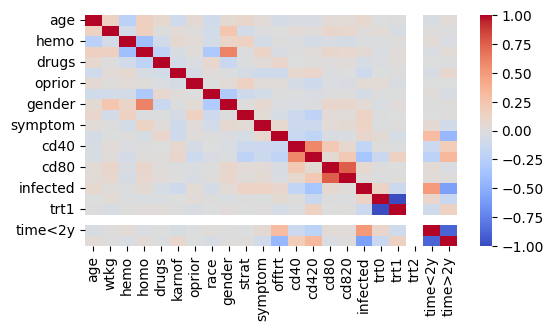

In [44]:
sns.heatmap(data_eng_simple.corr(),cmap='coolwarm', vmin = -1, vmax = 1)

### 017 Numerical outliers

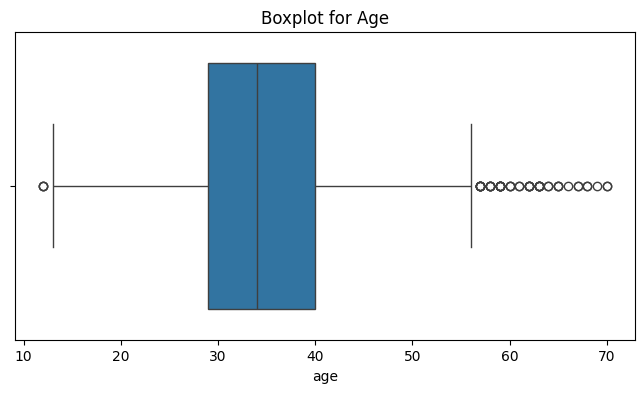

Outliers Below Lower Bound:
      age
2051   12
2069   12
2072   12

Outliers Above Upper Bound:
      age
1      61
49     67
100    64
104    70
170    65
217    60
229    59
239    59
253    63
256    63
261    59
269    59
271    68
282    59
325    57
331    66
349    57
415    63
474    60
506    57
508    62
518    68
541    58
583    64
619    58
664    58
711    63
763    65
787    59
801    58
880    63
889    65
935    57
990    59
992    62
1104   62
1149   69
1159   70
1303   67
1537   57
1578   57
1628   58
1641   59
1714   61
1845   57
1902   63
1917   60
1995   62
2028   62


In [45]:
df = pd.read_csv('data/AIDS_Classification.csv')
plt.figure(figsize=(8,4))
sns.boxplot(x=df['age'])
plt.title('Boxplot for Age')
plt.show()

Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_below = df[df['age'] < lower_bound] 
outliers_above = df[df['age'] > upper_bound] 

print("Outliers Below Lower Bound:")
print(outliers_below[['age']])
print("\nOutliers Above Upper Bound:")
print(outliers_above[['age']])


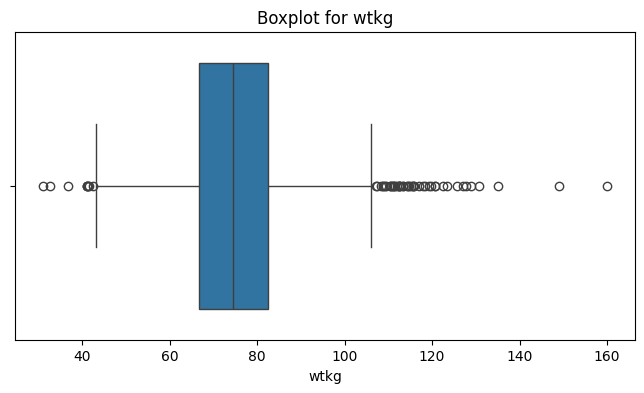

Outliers Below Lower Bound:
          wtkg
920   42.41160
1047  41.00000
1562  41.27760
1931  36.78696
2014  32.65920
2051  41.40000
2062  41.05080
2072  31.00000
2078  41.00000

Outliers Above Upper Bound:
           wtkg
126   111.00000
146   109.50000
197   117.93600
214   115.21440
304   123.37920
319   111.58560
324   111.35880
389   108.86400
544   107.10000
580   118.38960
629   120.65760
637   110.67840
655   108.86400
681   111.13200
826   119.70000
945   130.63680
978   115.66800
989   110.70000
1060  127.70000
1084  149.00000
1172  112.00000
1177  129.00000
1244  112.49280
1326  112.49280
1371  109.31760
1387  114.53400
1402  115.90000
1441  127.00800
1522  113.40000
1525  114.30720
1569  125.64720
1615  110.45160
1622  122.47200
1638  117.02880
1707  159.93936
1751  113.40000
1759  112.71960
1763  107.50320
1773  135.17280
1837  120.65760
1943  112.50000
1962  119.29680
2032  108.41040
2034  114.76080
2057  115.53192


In [46]:
df = pd.read_csv('data/AIDS_Classification.csv')
plt.figure(figsize=(8,4))
sns.boxplot(x=df['wtkg'])
plt.title('Boxplot for wtkg')
plt.show()

Q1 = df['wtkg'].quantile(0.25)
Q3 = df['wtkg'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_below = df[df['wtkg'] < lower_bound] 
outliers_above = df[df['wtkg'] > upper_bound] 

print("Outliers Below Lower Bound:")
print(outliers_below[['wtkg']])
print("\nOutliers Above Upper Bound:")
print(outliers_above[['wtkg']])

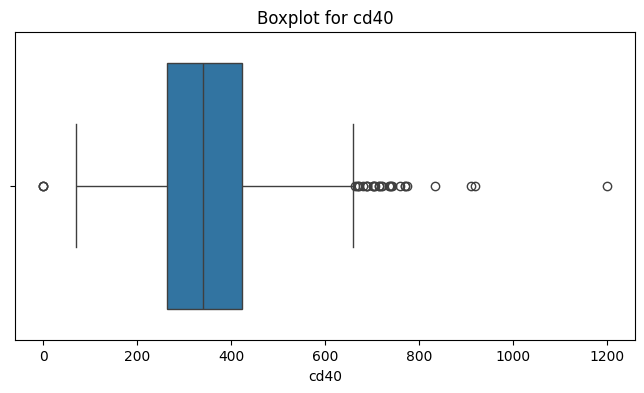

Outliers Below Lower Bound:
     cd40
216     0
217     0
723     0

Outliers Above Upper Bound:
      cd40
80     770
228    702
252    663
329    690
342    743
382    668
425    834
428    720
516    735
569    775
671    703
699    740
797    688
1047   714
1131   715
1135   689
1144  1199
1167   672
1190   670
1343   680
1360   760
1442   706
1481   918
1707   702
1847   771
2074   718
2120   739
2138   911


In [47]:
df = pd.read_csv('data/AIDS_Classification.csv')
plt.figure(figsize=(8,4))
sns.boxplot(x=df['cd40'])
plt.title('Boxplot for cd40')
plt.show()

Q1 = df['cd40'].quantile(0.25)
Q3 = df['cd40'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_below = df[df['cd40'] < lower_bound] 
outliers_above = df[df['cd40'] > upper_bound] 

print("Outliers Below Lower Bound:")
print(outliers_below[['cd40']])
print("\nOutliers Above Upper Bound:")
print(outliers_above[['cd40']])

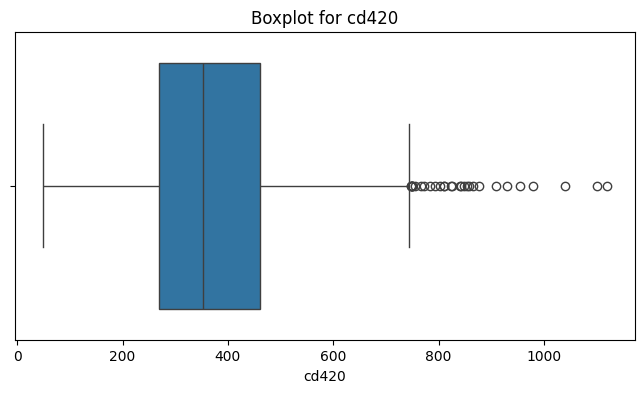

Outliers Below Lower Bound:
Empty DataFrame
Columns: [cd420]
Index: []

Outliers Above Upper Bound:
      cd420
132    1100
167    1119
398    1040
510     848
569     865
620     858
650     877
652     810
677     793
842     803
911     772
958     842
1331    750
1334    750
1391    750
1411    750
1442    853
1475    767
1485    748
1606    784
1625    748
1646    909
1720    824
1781    980
1882    755
1919    955
1936    840
1996    810
2069    826
2138    930


In [48]:
df = pd.read_csv('data/AIDS_Classification.csv')
plt.figure(figsize=(8,4))
sns.boxplot(x=df['cd420'])
plt.title('Boxplot for cd420')
plt.show()

Q1 = df['cd420'].quantile(0.25)
Q3 = df['cd420'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_below = df[df['cd420'] < lower_bound] 
outliers_above = df[df['cd420'] > upper_bound] 

print("Outliers Below Lower Bound:")
print(outliers_below[['cd420']])
print("\nOutliers Above Upper Bound:")
print(outliers_above[['cd420']])

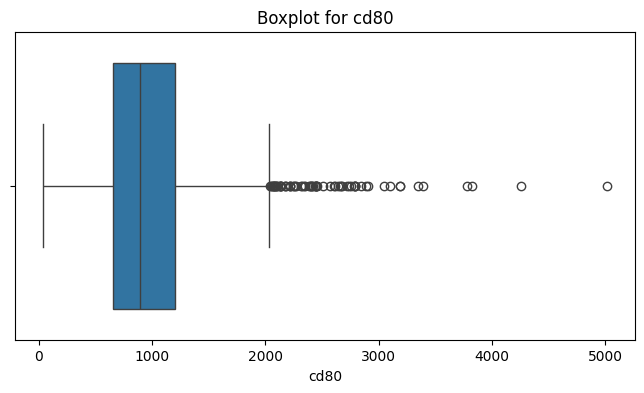

Outliers Below Lower Bound:
Empty DataFrame
Columns: [cd80]
Index: []

Outliers Above Upper Bound:
      cd80
2     2063
28    2400
35    2127
85    2040
121   2326
...    ...
2058  2784
2068  3046
2095  2387
2119  2508
2124  5011

[71 rows x 1 columns]


In [49]:
df = pd.read_csv('data/AIDS_Classification.csv')
plt.figure(figsize=(8,4))
sns.boxplot(x=df['cd80'])
plt.title('Boxplot for cd80')
plt.show()

Q1 = df['cd80'].quantile(0.25)
Q3 = df['cd80'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_below = df[df['cd80'] < lower_bound] 
outliers_above = df[df['cd80'] > upper_bound] 

print("Outliers Below Lower Bound:")
print(outliers_below[['cd80']])
print("\nOutliers Above Upper Bound:")
print(outliers_above[['cd80']])

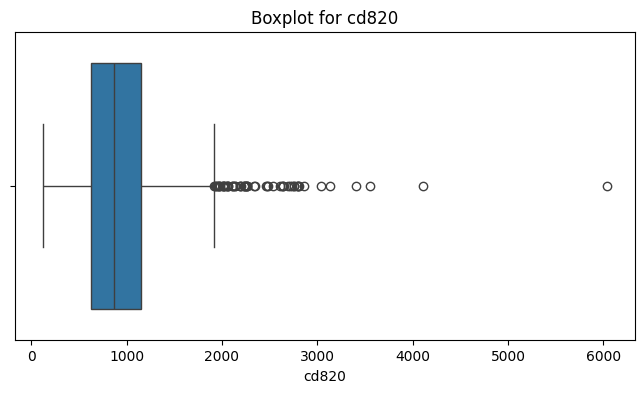

Outliers Below Lower Bound:
Empty DataFrame
Columns: [cd820]
Index: []

Outliers Above Upper Bound:
      cd820
28     2265
35     2753
63     2014
65     1947
148    2474
287    2056
313    2119
324    2068
353    2641
470    2241
481    2106
502    2250
550    2016
580    3044
649    2064
650    2807
732    2262
742    1942
764    2753
772    2736
807    2012
839    2132
890    2640
896    2232
907    4113
958    2028
982    2462
1020   2534
1022   2232
1046   2190
1156   2333
1199   2486
1219   1965
1233   2789
1236   3407
1269   2190
1297   2134
1311   2205
1323   2020
1438   2627
1445   2240
1493   1926
1527   2856
1533   1921
1561   3552
1571   1963
1585   2713
1605   2117
1607   2801
1755   2266
1768   1970
1786   2050
1847   2347
1890   2606
1937   2690
1939   1980
1997   3130
2068   2798
2124   6035


In [50]:
df = pd.read_csv('data/AIDS_Classification.csv')
plt.figure(figsize=(8,4))
sns.boxplot(x=df['cd820'])
plt.title('Boxplot for cd820')
plt.show()

Q1 = df['cd820'].quantile(0.25)
Q3 = df['cd820'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_below = df[df['cd820'] < lower_bound] 
outliers_above = df[df['cd820'] > upper_bound] 

print("Outliers Below Lower Bound:")
print(outliers_below[['cd820']])
print("\nOutliers Above Upper Bound:")
print(outliers_above[['cd820']])

## 018 Categorical Relationships ##

trt: treatment indicator (0 = ZDV only; 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only)
infected: is infected with AIDS (0=No, 1=Yes)


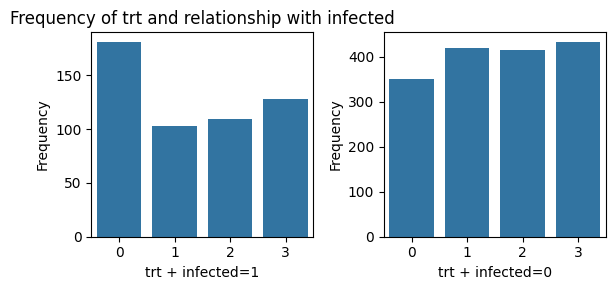

In [51]:
print("\033[1mtrt: treatment indicator (0 = ZDV only; 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='trt', data=filtered_data, ax=axes[0])
sns.countplot(x='trt', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("trt + infected=1")
axes[1].set_xlabel("trt + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of trt and relationship with infected")
plt.tight_layout()
plt.show()

hemo: hemophilia (0=no, 1=yes)
infected: is infected with AIDS (0=No, 1=Yes)


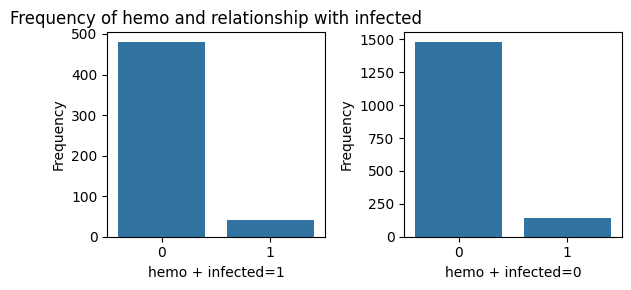

In [52]:
print("\033[1mhemo: hemophilia (0=no, 1=yes)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='hemo', data=filtered_data, ax=axes[0])
sns.countplot(x='hemo', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("hemo + infected=1")
axes[1].set_xlabel("hemo + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of hemo and relationship with infected")
plt.tight_layout()
plt.show()

homo: homosexual activity (0=no, 1=yes)
infected: is infected with AIDS (0=No, 1=Yes)


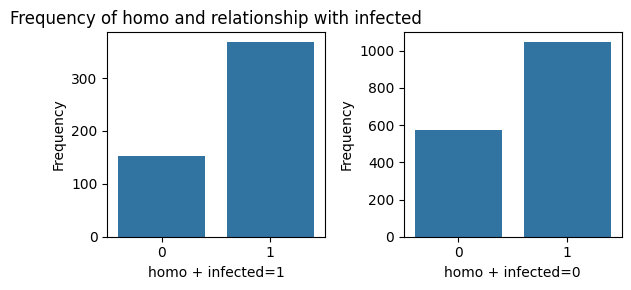

In [53]:
print("\033[1mhomo: homosexual activity (0=no, 1=yes)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='homo', data=filtered_data, ax=axes[0])
sns.countplot(x='homo', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("homo + infected=1")
axes[1].set_xlabel("homo + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of homo and relationship with infected")
plt.tight_layout()
plt.show()

drugs: history of IV drug use (0=no, 1=yes)
infected: is infected with AIDS (0=No, 1=Yes)


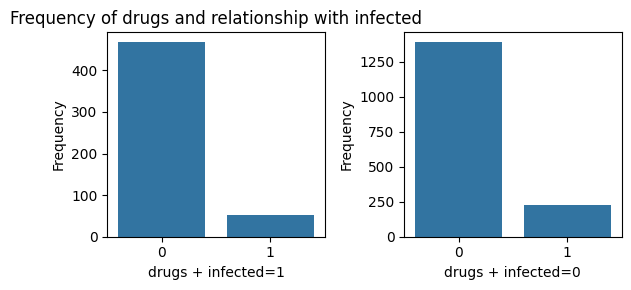

In [54]:
print("\033[1mdrugs: history of IV drug use (0=no, 1=yes)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='drugs', data=filtered_data, ax=axes[0])
sns.countplot(x='drugs', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("drugs + infected=1")
axes[1].set_xlabel("drugs + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of drugs and relationship with infected")
plt.tight_layout()
plt.show()

oprior: Non-ZDV antiretroviral therapy pre-175 (0=no, 1=yes)
infected: is infected with AIDS (0=No, 1=Yes)


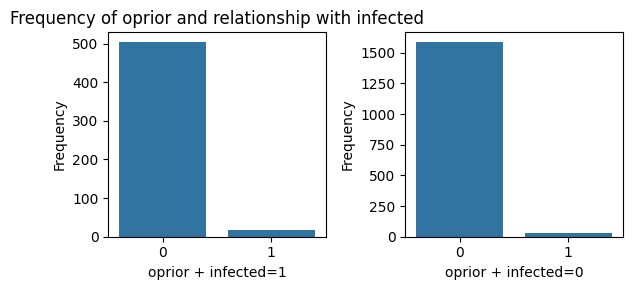

In [55]:
print("\033[1moprior: Non-ZDV antiretroviral therapy pre-175 (0=no, 1=yes)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='oprior', data=filtered_data, ax=axes[0])
sns.countplot(x='oprior', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("oprior + infected=1")
axes[1].set_xlabel("oprior + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of oprior and relationship with infected")
plt.tight_layout()
plt.show()

z30: ZDV in the 30 days prior to 175 (0=no, 1=yes)
infected: is infected with AIDS (0=No, 1=Yes)


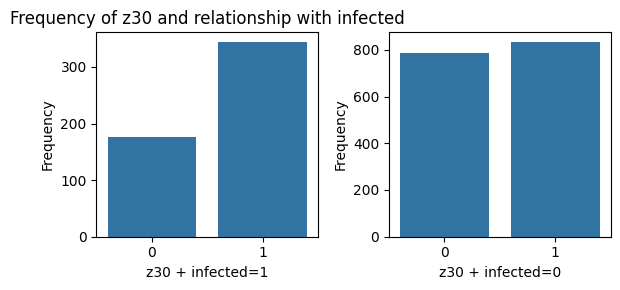

In [56]:
print("\033[1mz30: ZDV in the 30 days prior to 175 (0=no, 1=yes)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='z30', data=filtered_data, ax=axes[0])
sns.countplot(x='z30', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("z30 + infected=1")
axes[1].set_xlabel("z30 + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of z30 and relationship with infected")
plt.tight_layout()
plt.show()

str2: antiretroviral history (0=naive, 1=experienced)
infected: is infected with AIDS (0=No, 1=Yes)


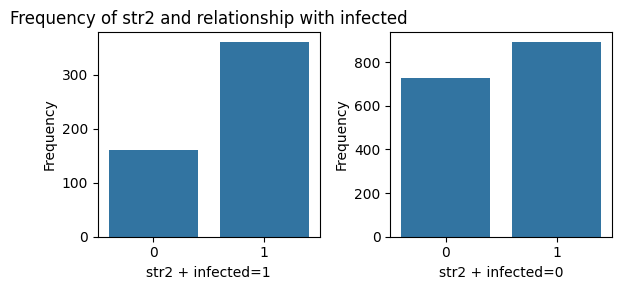

In [57]:
print("\033[1mstr2: antiretroviral history (0=naive, 1=experienced)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='str2', data=filtered_data, ax=axes[0])
sns.countplot(x='str2', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("str2 + infected=1")
axes[1].set_xlabel("str2 + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of str2 and relationship with infected")
plt.tight_layout()
plt.show()

strat: antiretroviral history stratification (1='Antiretroviral Naive',2='> 1 but <= 52 weeks of prior antiretroviral therapy',3='> 52 weeks)
infected: is infected with AIDS (0=No, 1=Yes)


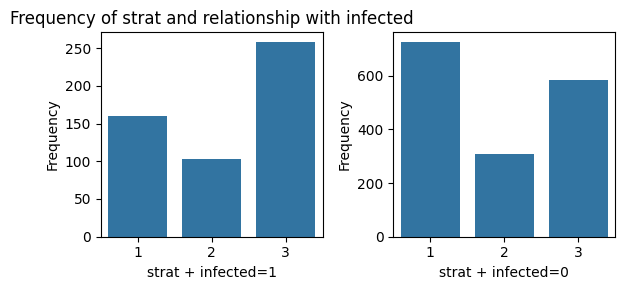

In [58]:
print("\033[1mstrat: antiretroviral history stratification (1='Antiretroviral Naive',2='> 1 but <= 52 weeks of prior antiretroviral therapy',3='> 52 weeks)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='strat', data=filtered_data, ax=axes[0])
sns.countplot(x='strat', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("strat + infected=1")
axes[1].set_xlabel("strat + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of strat and relationship with infected")
plt.tight_layout()
plt.show()

symptom: symptomatic indicator (0=asymp, 1=symp)
infected: is infected with AIDS (0=No, 1=Yes)


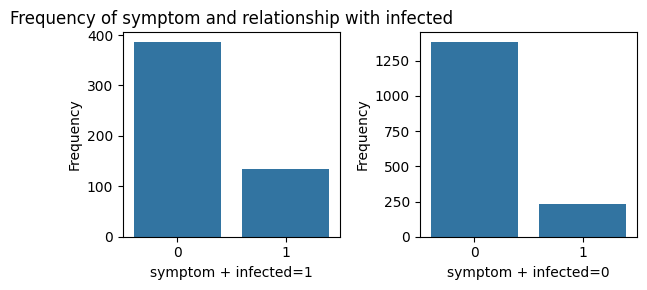

In [59]:
print("\033[1msymptom: symptomatic indicator (0=asymp, 1=symp)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='symptom', data=filtered_data, ax=axes[0])
sns.countplot(x='symptom', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("symptom + infected=1")
axes[1].set_xlabel("symptom + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of symptom and relationship with infected")
plt.tight_layout()
plt.show()

treat: treatment indicator (0=ZDV only, 1=others)
infected: is infected with AIDS (0=No, 1=Yes)


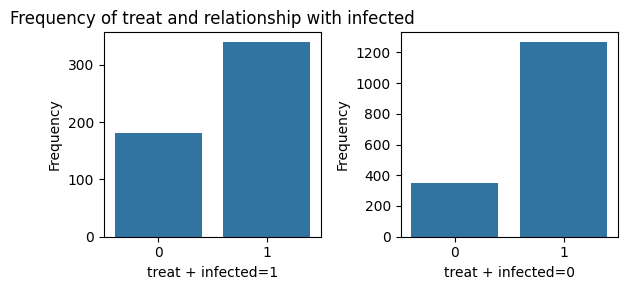

In [60]:
print("\033[1mtreat: treatment indicator (0=ZDV only, 1=others)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='treat', data=filtered_data, ax=axes[0])
sns.countplot(x='treat', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("treat + infected=1")
axes[1].set_xlabel("treat + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of treat and relationship with infected")
plt.tight_layout()
plt.show()

offtrt: indicator of off-trt before 96+/-5 weeks (0=no,1=yes)
infected: is infected with AIDS (0=No, 1=Yes)


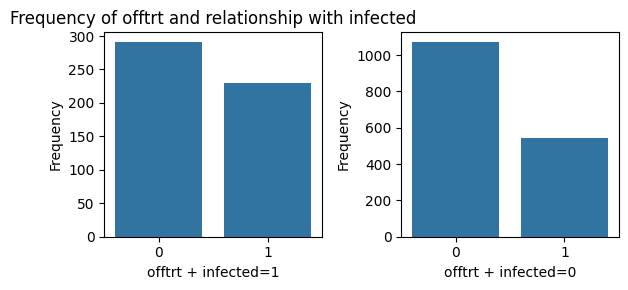

In [61]:
print("\033[1mofftrt: indicator of off-trt before 96+/-5 weeks (0=no,1=yes)\033[0m")
print("\033[1minfected: is infected with AIDS (0=No, 1=Yes)\033[0m")
filtered_data = data[data['infected'] == 1]
filtered_data1= data[data["infected"]==0]
fig,axes=plt.subplots(1,2)
sns.countplot(x='offtrt', data=filtered_data, ax=axes[0])
sns.countplot(x='offtrt', data=filtered_data1, ax=axes[1])
axes[0].set_xlabel("offtrt + infected=1")
axes[1].set_xlabel("offtrt + infected=0")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[0].set_title("Frequency of offtrt and relationship with infected")
plt.tight_layout()
plt.show()

### 019 Conditioned plots

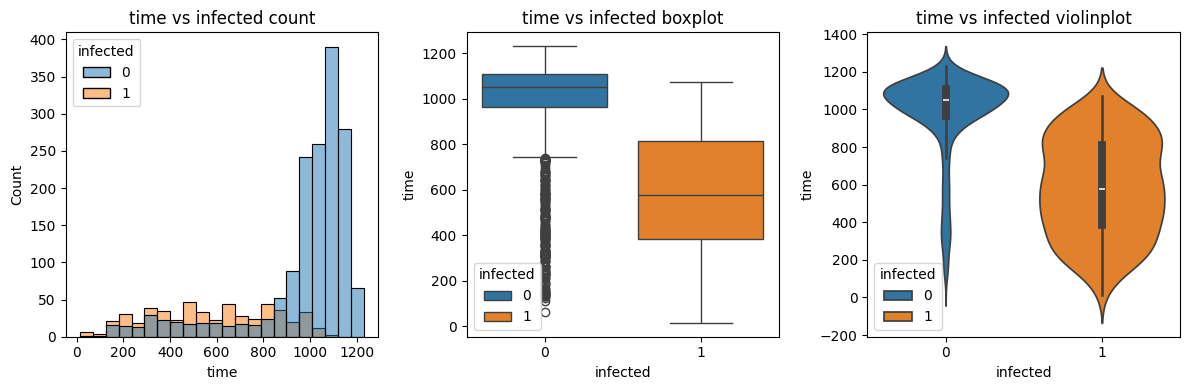

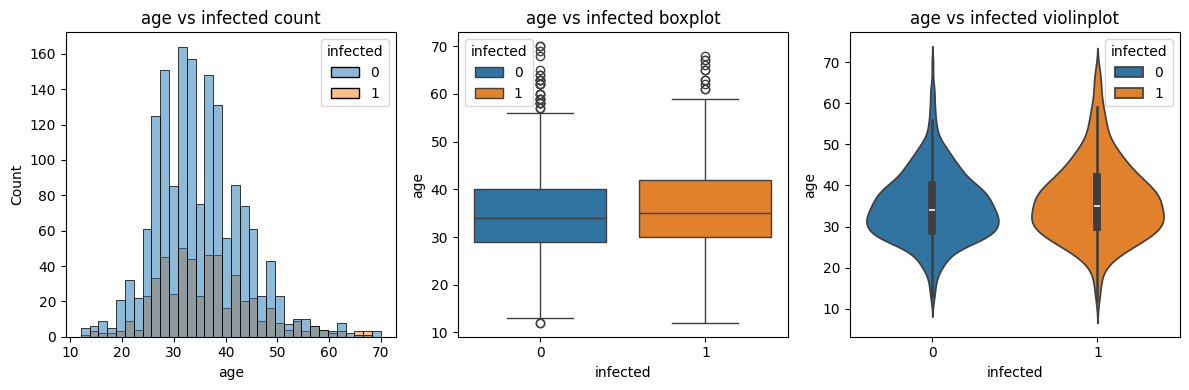

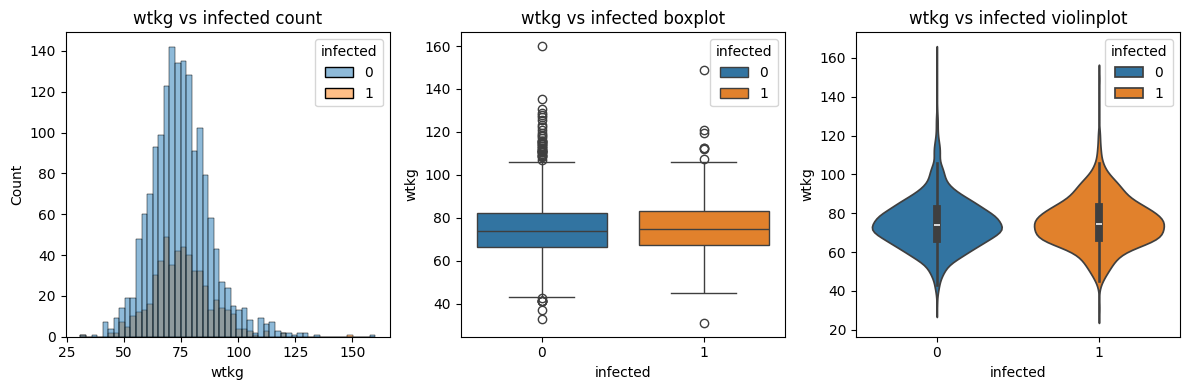

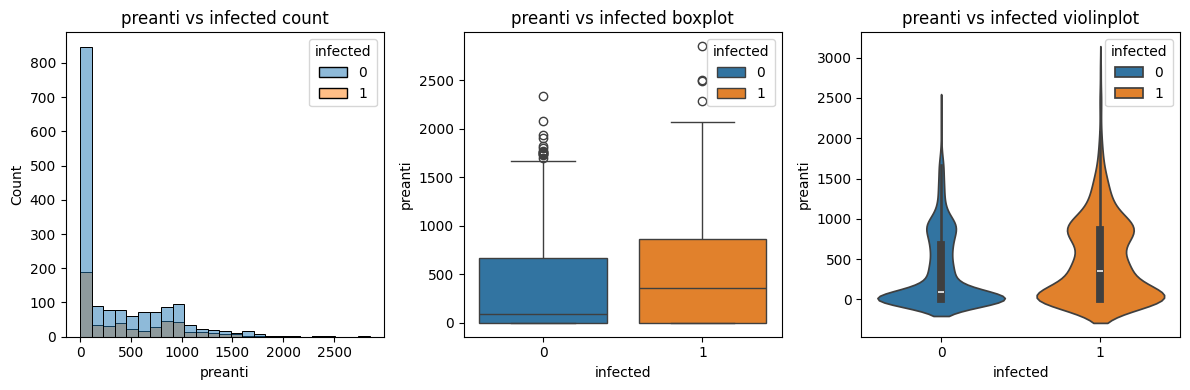

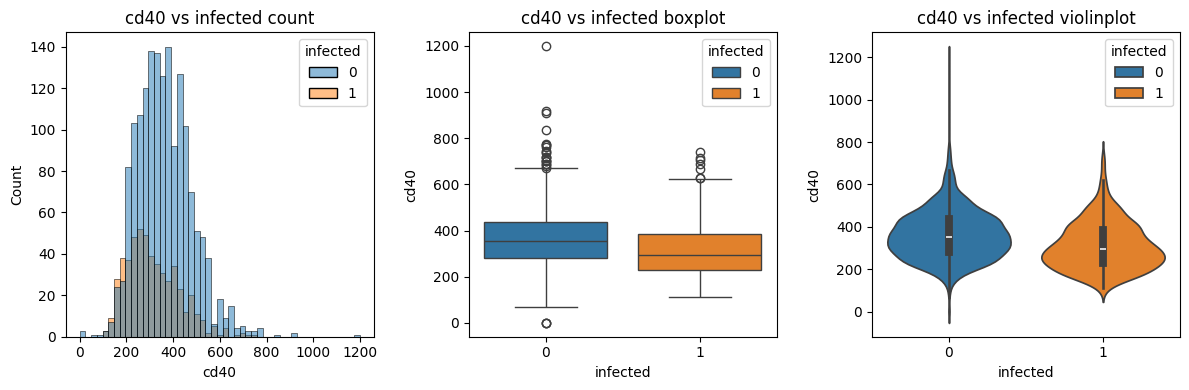

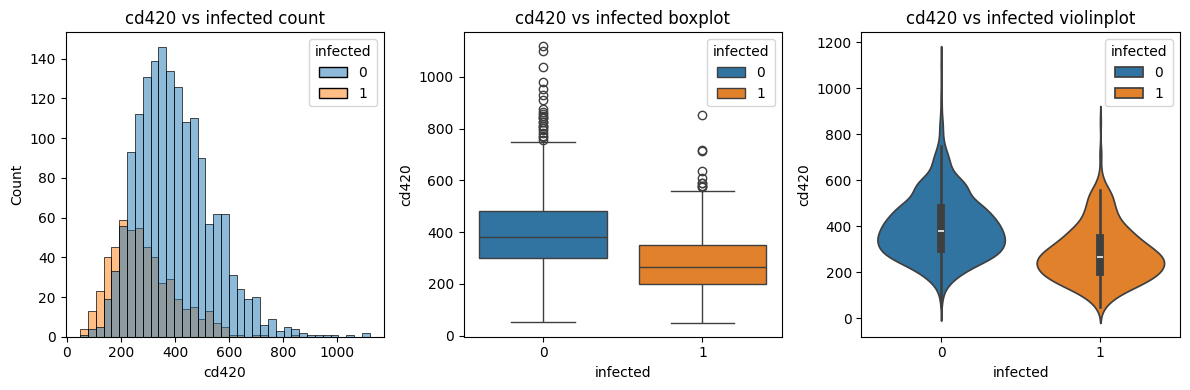

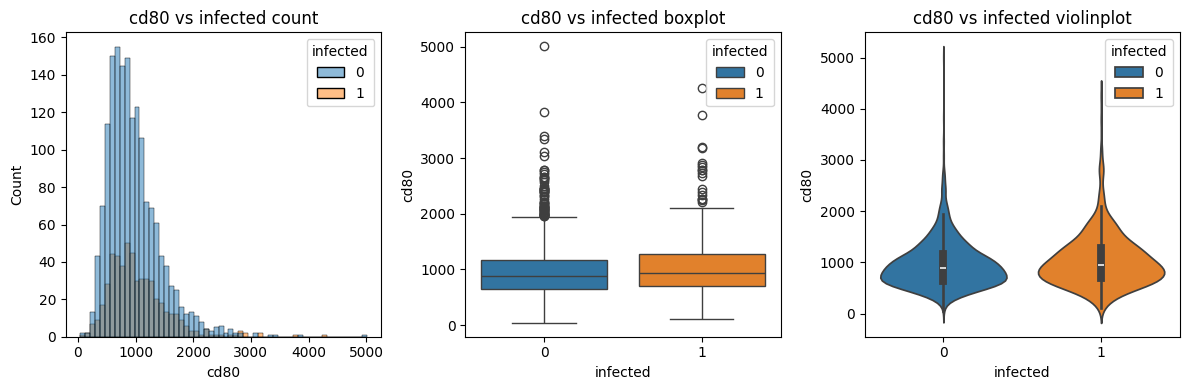

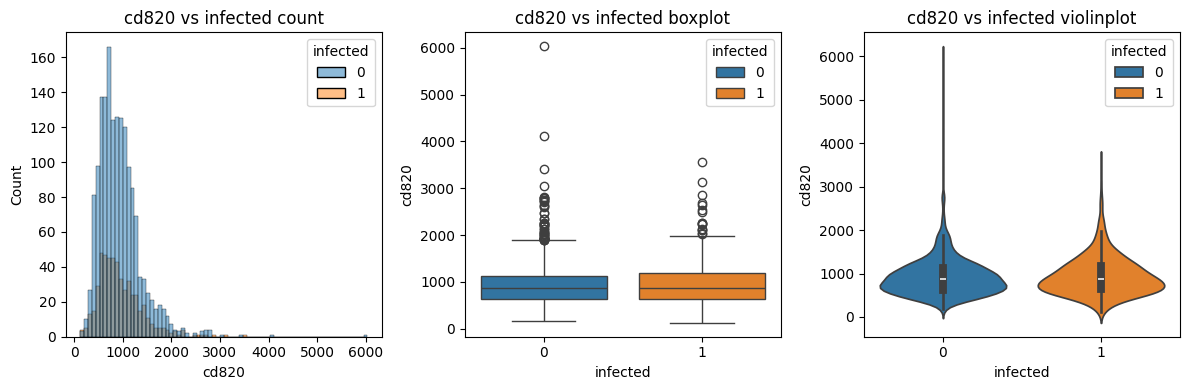

In [62]:
continuous_variables .remove('karnof')
for variable in continuous_variables:
    fig,axes = plt.subplots(1,3,figsize = (12,4), sharey = False)

    sns.histplot(data = data, x= variable, hue = "infected", ax = axes[0])
    sns.boxplot(data = data, x= "infected", y = variable, hue = "infected", orient = "v", ax = axes[1])
    sns.violinplot(data = data, x= "infected", y = variable, hue = "infected", orient = "v", ax = axes[2])


    axes[0].set_title(f'{variable} vs infected count')
    axes[1].set_title(f'{variable} vs infected boxplot')
    axes[2].set_title(f'{variable} vs infected violinplot')

    plt.tight_layout()
    plt.show()

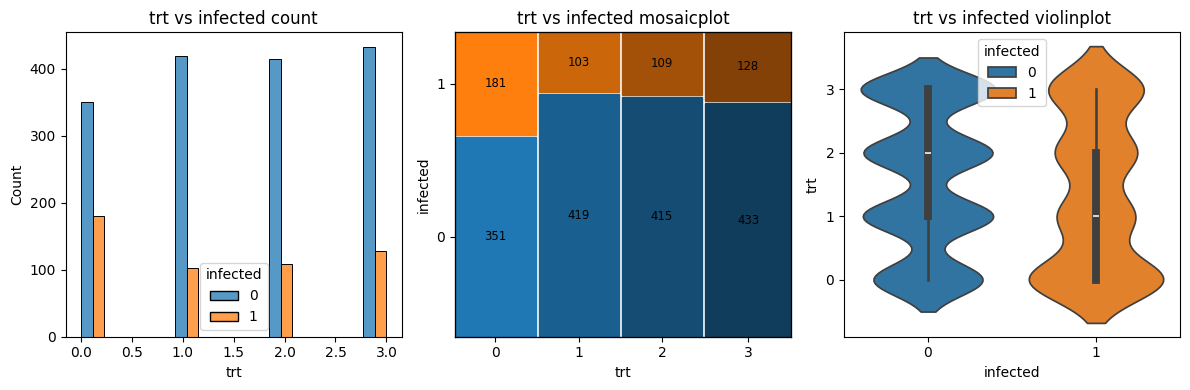

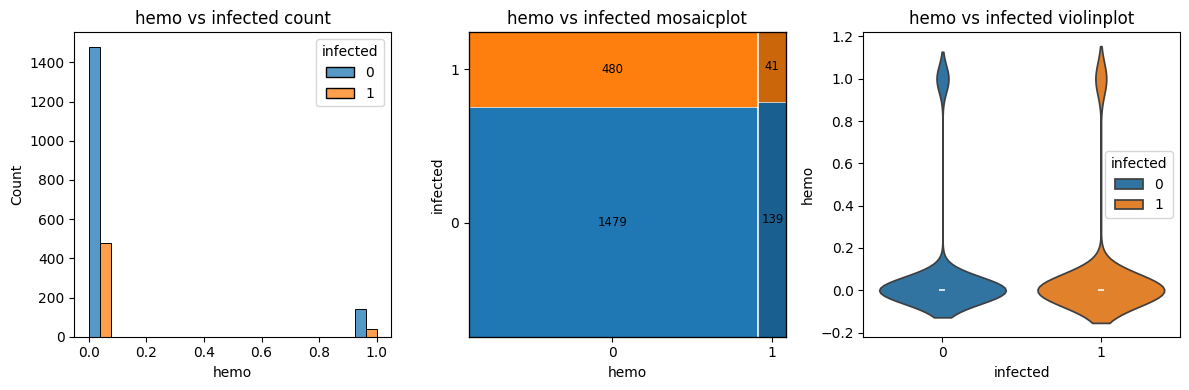

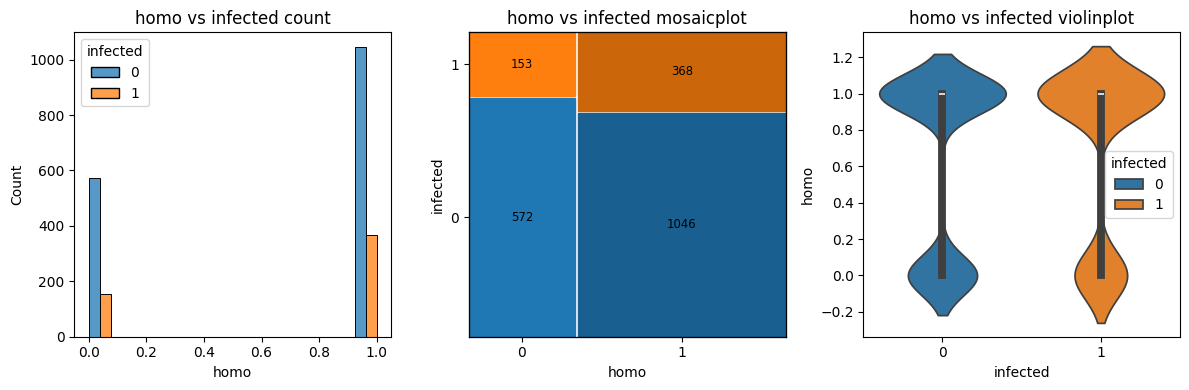

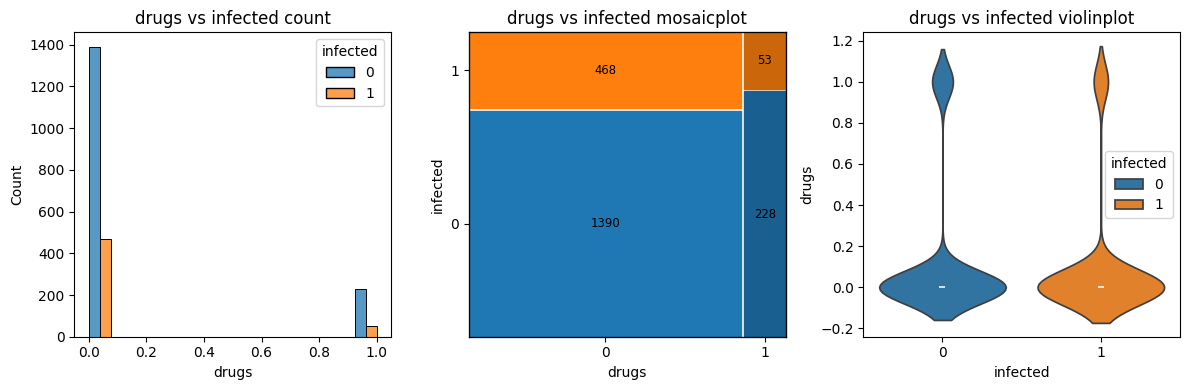

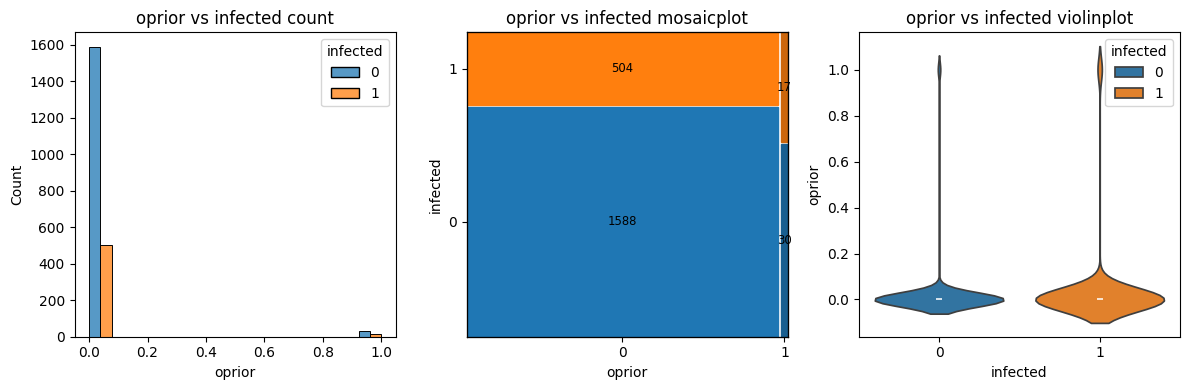

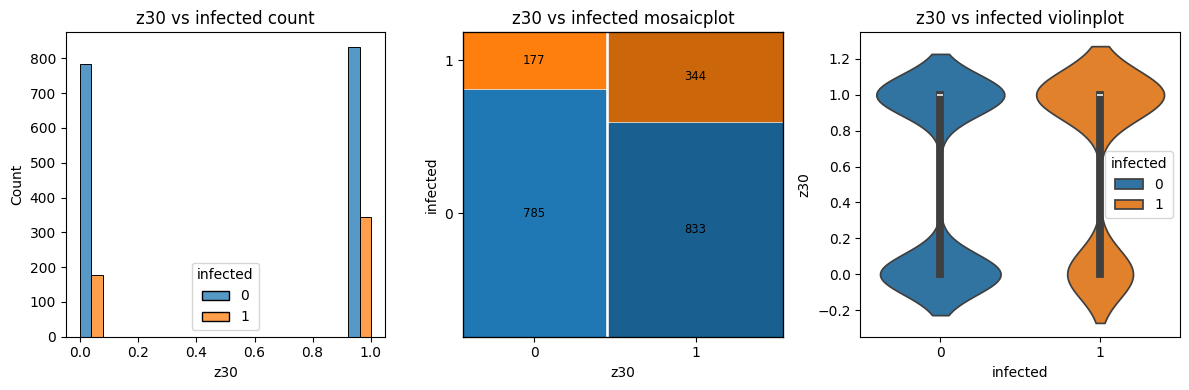

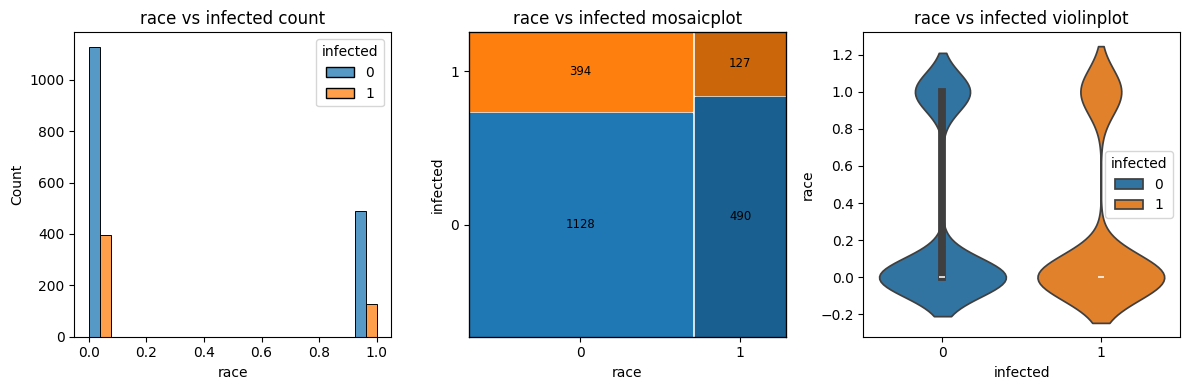

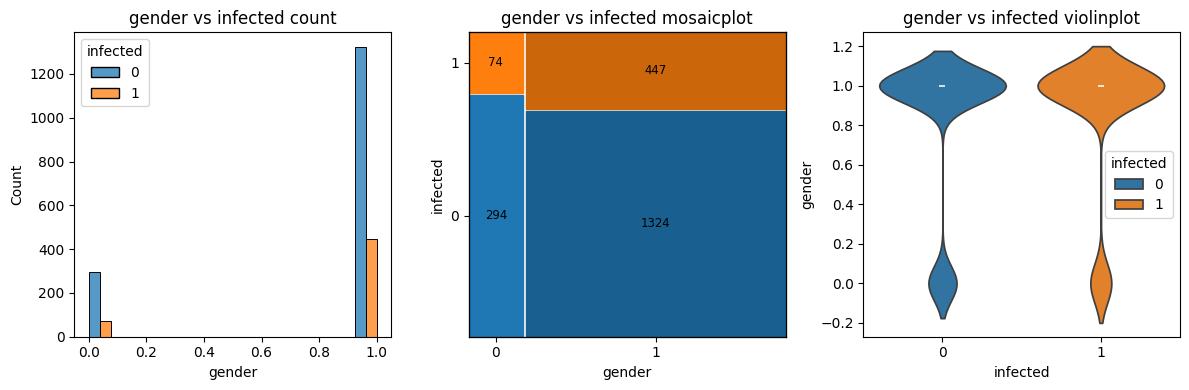

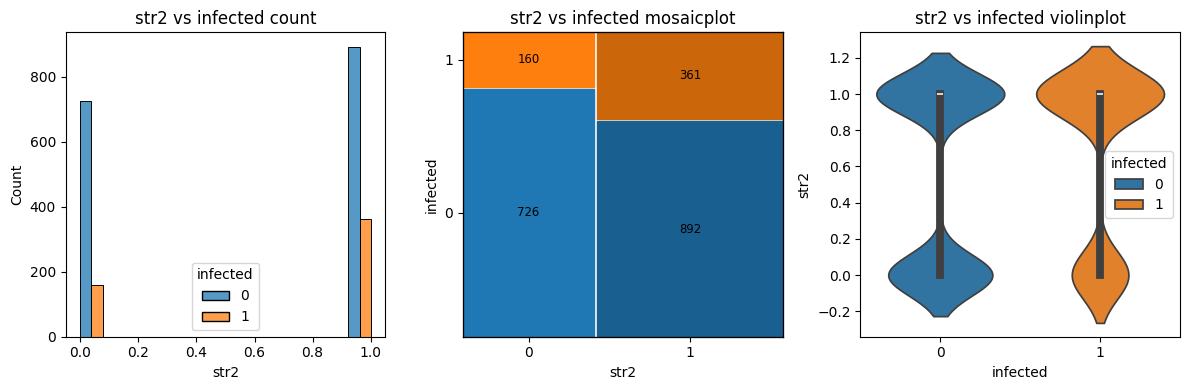

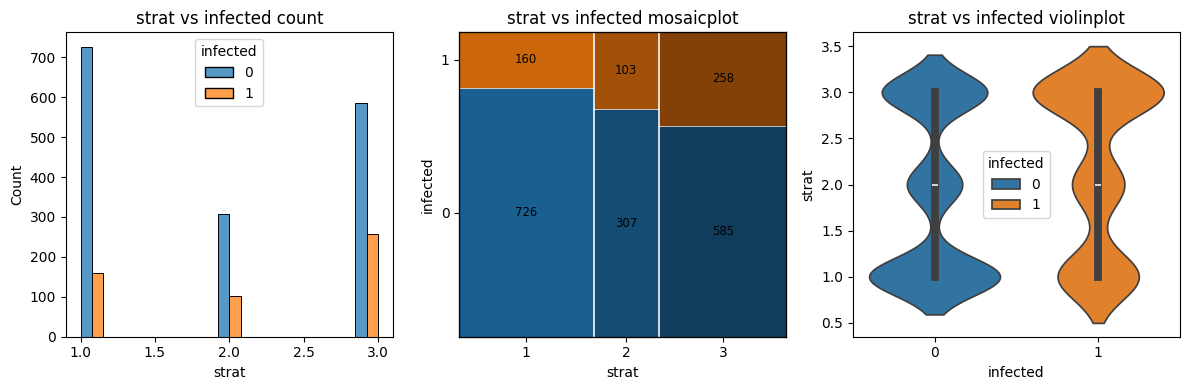

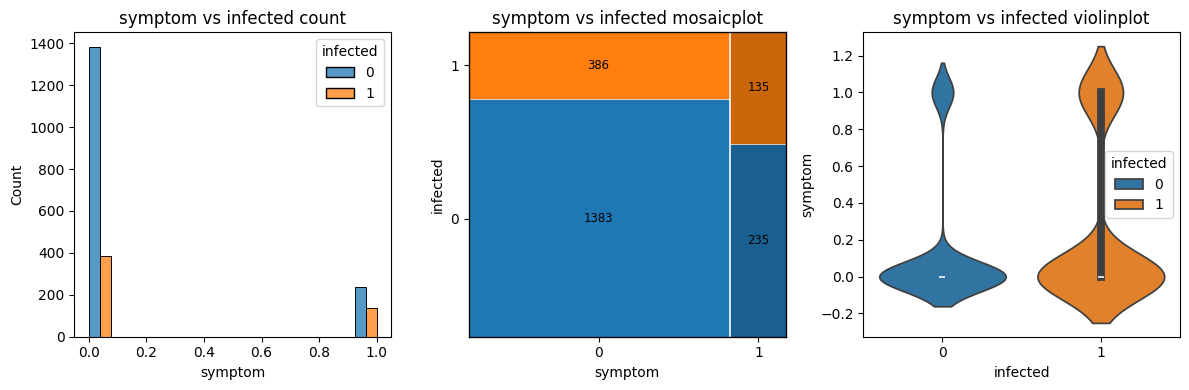

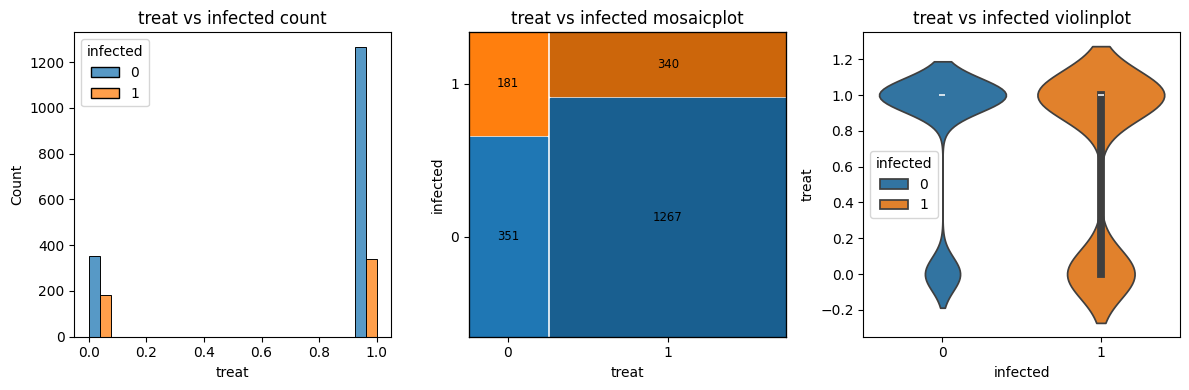

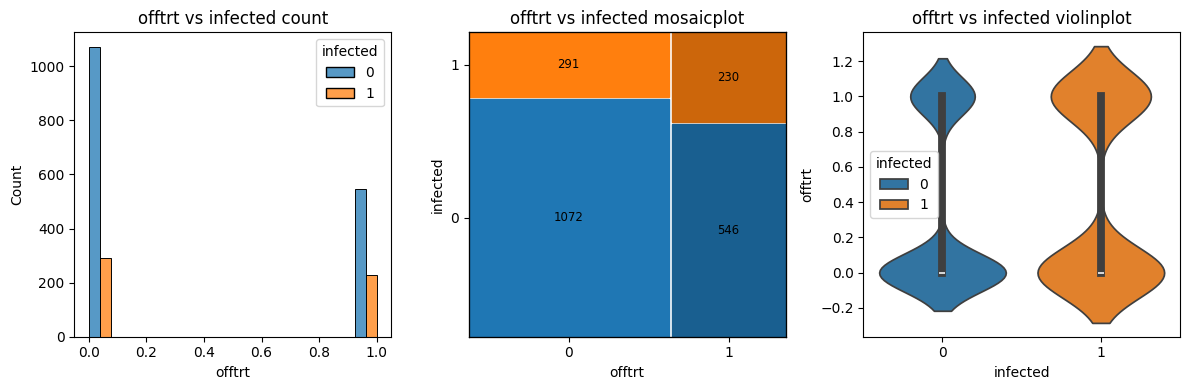

ValueError: Could not interpret value `karnof/100` for `x`. An entry with this name does not appear in `data`.

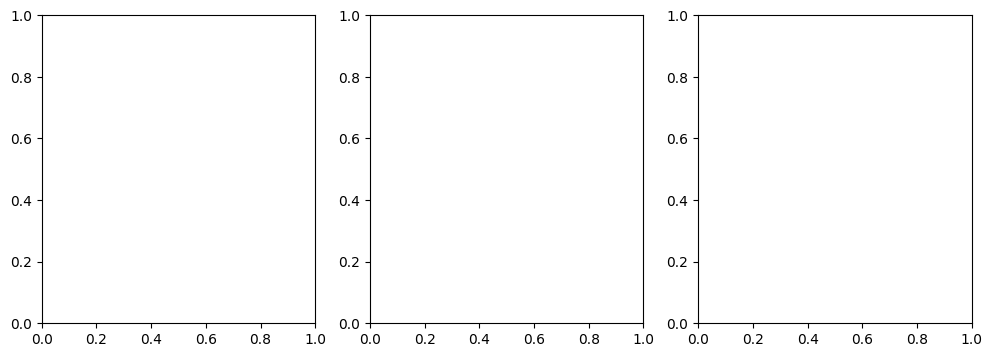

In [63]:
from statsmodels.graphics.mosaicplot import mosaic

def mosaic_colors(key):
    colors = sns.color_palette()
    infected = int(key[1])
    variable = int(key[0])
    base_color_rgb = colors[0] if infected == 0 else colors[1]
    scale_color = (0.8)**variable
    return_color = [x*scale_color for x in base_color_rgb]
    return {'color': return_color}


df = data.copy()
df['karnof/100'] = df['karnof']/100 # for the color of mosaicplot

categorical_features = [col for col in data.columns if col not in continuous_variables and col != 'infected']
categorical_features.remove('karnof')
categorical_features.append('karnof/100')
for variable in categorical_features:
    fig,axes = plt.subplots(1,3,figsize = (12,4), sharey = False)

    sns.histplot(data = data, x= variable, hue = "infected", multiple = "dodge", ax = axes[0])
    mosaic(data.sort_values(by=[variable,"infected"]), [variable,'infected'], axes_label = True, gap = 0.01, ax = axes[1],
        properties = mosaic_colors,
        labelizer = lambda key : str(data.groupby([variable,'infected']).size()[int(key[0]),int(key[1])])
    )
    sns.violinplot(data = data, x= "infected", y = variable, hue = "infected", orient = "v", ax = axes[2])


    axes[0].set_title(f'{variable} vs infected count')
    axes[1].set_title(f'{variable} vs infected mosaicplot')
    axes[1].set_xlabel(f"{variable}")
    axes[1].set_ylabel("infected")
    axes[2].set_title(f'{variable} vs infected violinplot')

    plt.tight_layout()
    plt.show()

## 022 Potential gaps or limitations in the dataset

#### Missing med variables 

Problems with the end reason of treatment
- the variable "time" tells us the total time a patient followed the treatment till failure or censoring. However, the data does not tell us the full story of the ending of treatment. Censoring could be among, but not limited to, the following reasons:
    - patient lost to follow-up
    - death
    - patient change tratment because of medical reasons
    - end of clinical study
- although the endstate should not be a regressor in the machine learning model, it could have been a feature to learn for an intermediate model.

Missing specification of symptoms and karnofsky score
- could be useful to know if the patient experiences 
    - weight loss, 
    - abnormal liver markers 
    - other medical data related to early AIDS diagnosis



#### Imbalancedness

Imbalanced target
- we have "infected = 1" only for 26% of records

Imbalanced features
- there are some notable under-represented categories, namely
    - gender = 0
    - drugs = 1
    - hemo = 1
    - karnof < 90

Some very under-represented features
- There is very limited data with respect to the following categories
    - oprior = 1
    - karnof = 70

#### Outliers

The following datapoints should be considered as outliers and managed with care
- wtkg > 110
- age < 18  or age > 60
- cd40, cd420 > 800
- cd80, cd820 > 2500

The time distributions are very skewed
- time is mostly supported on time > 800 but has uniform outliers in [0,800]
- preanti is mostly supported on preanti= 0 (where it is equivalent to st2 = 0 or strat = 1)

The lab distributions are supported on the nonnegative numbers
- therefore they are positively skewed

# Sprint 2

### 026 Preprocessing - Balance Dataset

As we saw in section [009 Target class imbalance](#009) the target feature is imbalanced. There are 1618 vs 521 datapoints for the classes infected and not infected. 
- We implement a simple balancing strategy.

In [ ]:
def sample_balance_df(dataset, with_reindex = False):
    df = dataset.copy()
    df_infected = df[df['infected']==1] 
    df_not_infected = df[df['infected']==0]

    num_infected = df_infected.shape[0]
    df_sample_not_infected = df_not_infected.sample(num_infected, random_state=42)

    df_balanced = pd.concat([df_infected,df_sample_not_infected])
    # we shuffle it once more at the end.
    # https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
    if with_reindex:
        df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
    else:
        df_balanced = df_balanced.sample(frac=1)
    return df_balanced

data_original = data.copy()
data_balanced = sample_balance_df(data_original)
print(data_balanced.shape)

(1042, 23)


### 027 Show balancing impact

The new data is balanced with respect to the target variable 'infected'

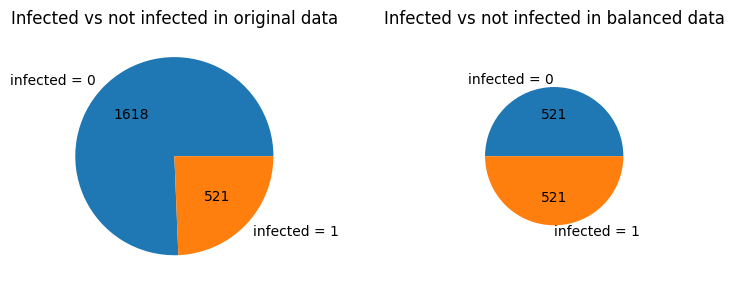

In [ ]:
fig,ax = plt.subplots(1,2, figsize = (8,3))

tot_num_data = data_original.shape[0]

for i,df in enumerate([data_original, data_balanced]):
        num_data = df.shape[0]
        text_data = ["original data", "balanced data"][i]
        ax[i].pie(df['infected'].value_counts(), 
                labels = ["infected = 0", "infected = 1"], 
                colors = sns.color_palette(), 
                radius = np.sqrt(num_data / tot_num_data),
                autopct= lambda p: f'{int(num_data * p / 100 )}') # to compute the count instead of the percentage
        ax[i].set_title(f"Infected vs not infected in {text_data}")

plt.tight_layout()
plt.show()



### 028 Train test split

In [ ]:
df = data_balanced
X = df.drop("infected",axis=1)
y = df['infected']

X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)


In [ ]:
df_train = pd.concat([X_train, y_train], axis = 1)

df_train 

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
1898,269,2,41,83.46240,0,0,0,100,0,1,...,1,3,0,1,1,232,182,901,682,1
1439,169,3,48,83.46240,0,0,0,90,0,0,...,0,1,0,1,1,291,328,617,686,1
2029,148,2,19,77.88312,1,0,0,90,0,1,...,1,3,0,1,1,315,237,1241,533,0
1303,299,0,67,82.10160,0,1,0,90,0,0,...,0,1,0,0,1,296,292,760,814,1
2133,1041,2,39,64.86480,1,0,0,90,0,1,...,1,3,0,1,1,378,401,504,367,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,595,1,48,77.70000,0,1,0,100,0,1,...,1,3,0,1,0,270,240,1220,980,1
367,984,3,25,73.00000,0,1,0,100,0,0,...,0,1,0,1,0,630,494,1328,817,0
1130,898,1,30,64.50000,0,1,0,100,0,1,...,1,2,1,1,0,350,292,833,794,1
897,263,0,46,90.72000,0,1,0,100,0,1,...,1,3,0,0,1,275,277,1822,1368,0


### 029 Visualization train test split proportions

X_train: (833, 22) X_test: (209, 22) y_train: (833,) y_test: (209,)


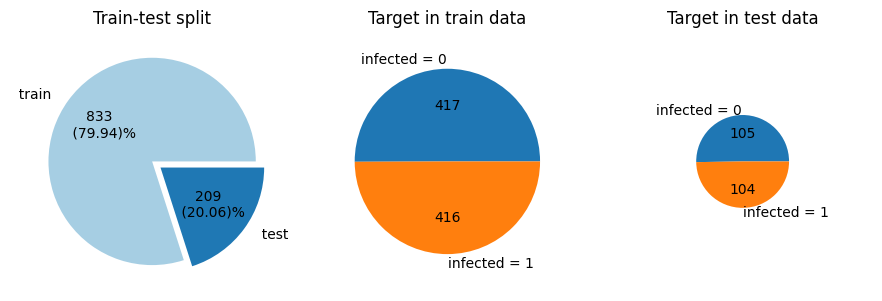

In [ ]:
fig,ax = plt.subplots(1,3, figsize = (9,5))

print("X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:",y_test.shape)

# Train/test proportion

num_train = X_train.shape[0]
num_test = X_test.shape[0]
num_data = num_train + num_test
ax[0].pie([num_train,num_test],
        labels = ["  train  ", "  test  "],
        explode = (0,0.1),
        colors = sns.color_palette("Paired"),    
        autopct= lambda p: f'{round(num_data * p / 100 )} \n ({round(100*p) /100})%') # to compute both the count and the percentage
ax[0].set_title(f"Train-test split")

tot_num_data = num_data

# Target proportion n train and test

df_train = pd.concat([X_train, y_train], axis = 1)
df_test = pd.concat([X_test, y_test], axis = 1)
for i,df in enumerate([df_train, df_test]):
        num_data = df.shape[0]
        text_data = ["train data", "test data"][i]
        ax[i+1].pie(df['infected'].value_counts(),
                labels = ["infected = 0", "infected = 1"], 
                colors = sns.color_palette(), 
                radius = np.sqrt(num_data/tot_num_data),
                autopct= lambda p: f'{round(num_data * p / 100 )}') #({round(100*p) /100})%') # to compute both the count and the percentage
        ax[i+1].set_title(f"Target in {text_data}")

plt.tight_layout()
plt.show()


## 030 boxplots for normalized variables +031 ##

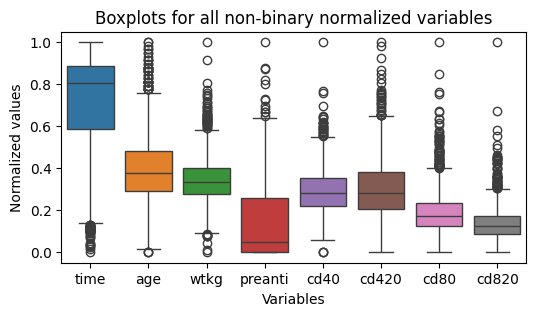

Outliers for preanti:

Below lower bound:
Empty DataFrame
Columns: [time, trt, age, wtkg, hemo, homo, drugs, karnof, oprior, z30, preanti, race, gender, str2, strat, symptom, treat, offtrt, cd40, cd420, cd80, cd820, infected]
Index: []

[0 rows x 23 columns]

Above upper bound:
      time  trt  age      wtkg  hemo  homo  drugs  karnof  oprior  z30  ...  \
292    314    0   54  68.49360     0     1      0      80       0    1  ...   
510   1186    1   38  78.92640     0     0      0      90       0    1  ...   
600   1139    1   30  66.80000     0     1      0      90       0    1  ...   
607    392    2   35  73.90000     0     1      0     100       0    1  ...   
806    312    1   42  76.10000     0     1      0      90       0    1  ...   
1289  1021    0   36  56.24640     0     1      1      90       0    1  ...   
1365   236    2   41  98.43120     0     1      0      90       0    1  ...   
1377   959    3   42  58.00000     0     1      0     100       0    1  ...   
1695   549

In [ ]:
data = pd.read_csv("./data/AIDS_Classification.csv")
non_binary_data = data.loc[:, data.nunique() > 4]
scaler = MinMaxScaler()
non_binary_scaled = scaler.fit_transform(non_binary_data)
non_binary_scaled_df = pd.DataFrame(non_binary_scaled, columns=non_binary_data.columns)

sns.boxplot(data=non_binary_scaled_df)
plt.title('Boxplots for all non-binary normalized variables')
plt.xlabel('Variables')
plt.ylabel('Normalized values')
plt.show()

outliers = {}

for col in ['preanti', 'cd40', 'cd420', 'cd80', 'cd820']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers[col] = {
        'below': data[data[col] < lower_bound],
        'above': data[data[col] > upper_bound]
    }
    print(f"Outliers for {col}:\n")
    print(f"Below lower bound:\n{outliers[col]['below']}\n")
    print(f"Above upper bound:\n{outliers[col]['above']}\n")

## 032 RFE Evaluation Loop ##

In [21]:
def rfe_select_features(X, y, k):
    estimator = LogisticRegression(solver="newton-cg",random_state=42)
    rfe = RFE(estimator=estimator, n_features_to_select=k)
    rfe = rfe.fit(X, y)
    selected_features = X.columns[rfe.support_]
    return selected_features

In [22]:
data730 = datasets.data_time730()

In [23]:
def rfe_evaluation_loop(data730, max_k=None, verbose=False):
    X = data730.drop('infected', axis=1)
    y = data730['infected']
    
    if max_k is None:
        max_k = len(X.columns)
    
    X_train, X_test, y_train, y_test = datasets.xy_train_test(data730)
    
    results_rfe = []
    for k in range(1, max_k+1):
        if verbose:
            print(f"Selecting {k} features")
        
        rfe_features = rfe_select_features(X_train, y_train, k)
        
        if verbose:
            print("selected features:", list(rfe_features))
        
        model = LogisticRegression(solver="newton-cg", random_state=42)
        model.fit(X_train[rfe_features], y_train)
        y_pred = model.predict(X_test[rfe_features])
        accuracy = accuracy_score(y_test, y_pred)
        
        results_rfe.append({
            "k": k, 
            "score": round(accuracy,4), 
            "features": list(rfe_features)
        })
    
    return pd.DataFrame(results_rfe).set_index('k')

In [24]:
data730 = datasets.data_time730()

results_rfe = rfe_evaluation_loop(data730, verbose=False)
results_df = rfe_evaluation_loop(data730)

best_k = results_df['score'].idxmax()
best_accuracy = results_df.loc[best_k, 'score']
best_features = results_df.loc[best_k, 'features']

print(results_rfe)
print(f"\noptimal number of features: {best_k} Accuracy: {best_accuracy:.2f}")

     score                                           features
k                                                            
1   0.8084                                          [time730]
2   0.8201                                  [offtrt, time730]
3   0.8692                           [offtrt, cd420, time730]
4   0.8832                  [preanti, offtrt, cd420, time730]
5   0.8902            [preanti, race, offtrt, cd420, time730]
6   0.8995  [preanti, race, offtrt, cd420, time730, time_c...
7   0.8972  [age, preanti, race, offtrt, cd420, time730, t...
8   0.9019  [age, z30, preanti, race, offtrt, cd420, time7...
9   0.9019  [age, z30, preanti, race, str2, offtrt, cd420,...
10  0.8972  [age, z30, preanti, race, str2, offtrt, cd420,...
11  0.9019  [age, z30, preanti, race, str2, symptom, offtr...
12  0.9042  [age, hemo, z30, preanti, race, str2, symptom,...
13  0.9089  [age, hemo, drugs, z30, preanti, race, str2, s...
14  0.9065  [age, hemo, drugs, karnof, z30, preanti, race,...
15  0.90

## 033 Plot RFE k vs Train Accuracy ##

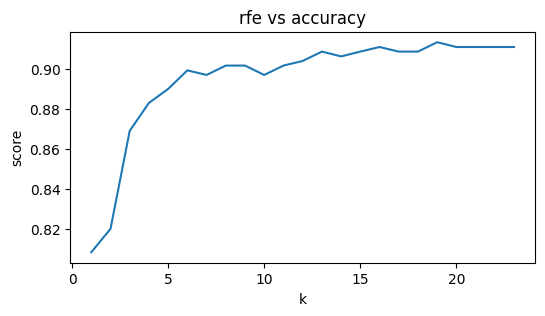

In [25]:
sns.lineplot(data = results_rfe, x = "k", y = "score")
plt.title("rfe vs accuracy")
plt.show()

## 034 Select k for RFE ##

In [26]:
rfe_selected_features=results_rfe.loc[8,"features"]    
print(f"selected features for rfe:8",rfe_selected_features)    

selected features for rfe:8 ['age', 'z30', 'preanti', 'race', 'offtrt', 'cd420', 'time730', 'time_censored']


## 035 SKB Evaluation loop

In [70]:
# SELECT K-BEST
def skb_select_features(X, y, k):
    skb = SelectKBest(score_func=f_classif, k = k)
    skb = skb.fit(X, y)
    selected_features = X.columns[skb.get_support(indices=True)]
    return selected_features

In [71]:
def skb_evaluation_loop(dataset = None, max_k = None, verbose = False):
    """ 
    returns : DataFrame with columns 
        k:: integer (number of features)
        score:: float (accuracy score against test set)
        features:: list (names of selected features)
    """
    if dataset is None:
        dataset = data_balanced()
    if max_k is None: 
        max_k = len(dataset.columns)-1

    X_train, X_test, y_train, y_test = xy_train_test(dataset)

    results_skb = []
    for k in range(1,max_k+1):
        if verbose:
            print("k", k)

        # calculate skb features
        skb_features = skb_select_features(X_train,y_train,k)

        if verbose: 
            print("skb_features", skb_features)

        # evaluate accuracy against the test data with logistic regression
        model = LogisticRegression(random_state = 42)
        model.fit(X_train[skb_features], y_train)
        y_pred = model.predict(X_test[skb_features])
        accuracy = accuracy_score(y_test, y_pred)

        # save all results
        results_skb.append({"k": k, "score": round(accuracy,4), "features":list(skb_features)})
    return pd.DataFrame(results_skb).set_index('k')



In [72]:
results_skb_df = skb_evaluation_loop(dataset = datasets.data_original())
print(results_skb_df)

     score                                           features
k                                                            
1   0.7827                                             [time]
2   0.8037                                      [time, cd420]
3   0.8014                                [time, cd40, cd420]
4   0.8014                         [time, treat, cd40, cd420]
5   0.8178                    [time, z30, treat, cd40, cd420]
6   0.8154              [time, z30, str2, treat, cd40, cd420]
7   0.8178     [time, z30, preanti, str2, treat, cd40, cd420]
8   0.8201  [time, z30, preanti, str2, symptom, treat, cd4...
9   0.8248  [time, karnof, z30, preanti, str2, symptom, tr...
10  0.8224  [time, karnof, z30, preanti, str2, strat, symp...
11  0.8435  [time, karnof, z30, preanti, str2, strat, symp...
12  0.8388  [time, trt, karnof, z30, preanti, str2, strat,...
13  0.8481  [time, trt, age, karnof, z30, preanti, str2, s...
14  0.8435  [time, trt, age, karnof, z30, preanti, str2, s...
15  0.85

## 036 Plot SKB vs accuracy

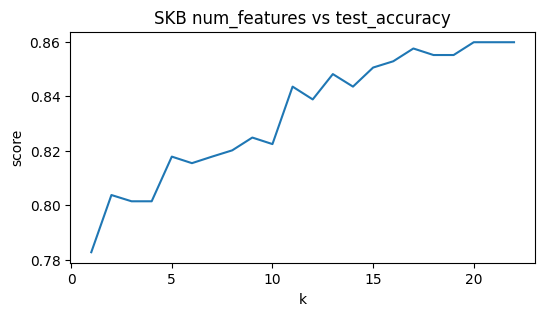

In [73]:
sns.lineplot(data = results_skb_df, x = "k", y = "score")
plt.title("SKB num_features vs test_accuracy")
plt.show()

## 037 Select k for SKB

The crucial learning improvements with SKB for the original dataset happen at $k=5,11,17$


In [74]:
for k in [5,11,17]:
    print("SKB accuracy with k =", k, ":", results_skb_df.loc[k,"score"] )
    print("    features: ", results_skb_df.loc[k,"features"] )

SKB accuracy with k = 5 : 0.8178
    features:  ['time', 'z30', 'treat', 'cd40', 'cd420']
SKB accuracy with k = 11 : 0.8435
    features:  ['time', 'karnof', 'z30', 'preanti', 'str2', 'strat', 'symptom', 'treat', 'offtrt', 'cd40', 'cd420']
SKB accuracy with k = 17 : 0.8575
    features:  ['time', 'trt', 'age', 'homo', 'drugs', 'karnof', 'z30', 'preanti', 'race', 'str2', 'strat', 'symptom', 'treat', 'offtrt', 'cd40', 'cd420', 'cd80']


The best comparison with RFE, as well the best subjective compromise between accuracy and number of features is $k=11$.

## 038 Compare RFE and SKB score 

In [ ]:
results_skb = skb_evaluation_loop(dataset = datasets.data_original())
results_rfe = rfe_evaluation_loop(data = datasets.data_original())

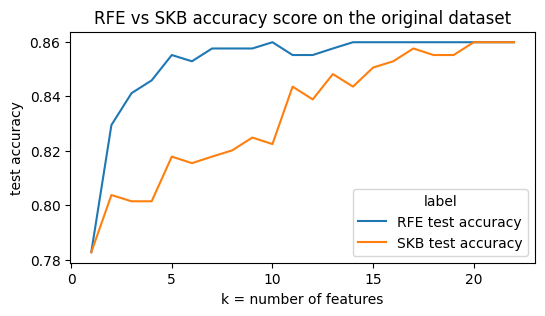

In [ ]:
results_skb['label'] = "SKB test accuracy" 
results_rfe['label'] = "RFE test accuracy"

results_all = pd.concat([results_rfe, results_skb])

sns.lineplot(data = results_all, x = "k", y = "score", hue="label")
plt.ylabel("test accuracy")
plt.xlabel("k = number of features")
plt.title("RFE vs SKB accuracy score on the original dataset")
plt.show()

## 039 Identify common features

In [ ]:
features_rfe = set(results_rfe.loc[10,"features"])
features_skb = set(results_skb.loc[11,"features"])

print("rfe, k=10 : ", features_rfe)
print("skb, k=11 : ", features_skb)

rfe, k=10 :  {'offtrt', 'cd420', 'race', 'preanti', 'z30', 'drugs', 'time', 'karnof', 'cd820', 'hemo'}
skb, k=11 :  {'offtrt', 'cd420', 'treat', 'preanti', 'cd40', 'z30', 'time', 'karnof', 'symptom', 'str2', 'strat'}


The following are the common features. They are important with respect to both methods.

In [ ]:
print(features_rfe.intersection(features_skb))


{'offtrt', 'cd420', 'preanti', 'z30', 'time', 'karnof'}


## 040 Venn diagram for feature selection 

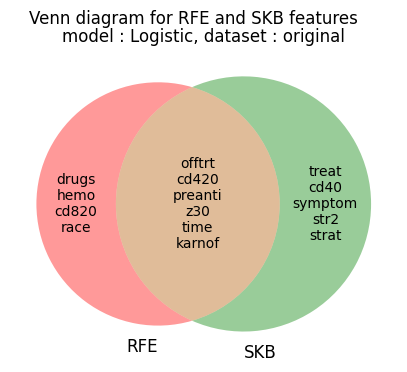

In [ ]:
# DIAGRAMMA DI VENN

set1 = features_rfe
set2 = features_skb

# Crea il diagramma di Venn
plt.figure(figsize=(8, 4))
venn_diagram = venn2([set1, set2], ('RFE', 'SKB'))

# Assegna i nomi delle parole alle etichette nelle aree corrispondenti del diagramma di Venn
venn_diagram.get_label_by_id('10').set_text('\n'.join(set1 - set2))
venn_diagram.get_label_by_id('11').set_text('\n'.join(set1 & set2))
venn_diagram.get_label_by_id('01').set_text('\n'.join(set2 - set1))

# Mostra il grafico
plt.suptitle("Venn diagram for RFE and SKB features")
plt.title("model : Logistic, dataset : original")
plt.show()

## 041 Argue Venn diagram insights

### Features are selected in both SKB and RFE. 

Very important features
- time : the time spent in treatment 
- cd420 : the number of CD T4 cells after 20 weeks of treatment 

Moderately important features 
- preanti : days spent in treatment before the study 
- z30 : if the patient was administered zidovudine prior to the study 

Features with probable important interactions
- karnof : the overall health status of the patient as measured by the karnof scale 
- offtrt : whether the patient went off-treatment within 96+-5 weeks (almost 2 years)






### Featuress selected in only SKB or only in RFE

Notable features selected in SKB:
- treat (probably interacting with other variables)
- cd40 (correlated with cd420)
- symptom (probably interacting with karnof)
- str2, strat (correlated with z30 and preanti)

Notable features selected in RFE:
- drugs, hemo, race (all slightly correlated with homo)
- cd820 indicating the status of infection after 20 weeks, probably important in rare cases


## Validation with K Fold Cross Validation


In [ ]:

def validation_accuracy_score(Xtrain,ytrain,model, n_splits = 5):
    # Create the K-Fold cross-validator
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation measuring the Accuracy
    scores = cross_val_score(
        model, Xtrain, ytrain, cv=cv, scoring='accuracy', n_jobs=-1
    )

    # Calculate the mean of the MSE scores
    mean_accuracy = scores.mean() 
    return mean_accuracy

## 043  Cross-Validation for RFE ##

In [75]:
data730 = datasets.data_time730()
X = data730.drop(columns=['infected'])
y = data730['infected']

In [76]:
def rfe_kfold_cv(X, y, max_k=None, cv=5):
    if max_k is None:
        max_k = X.shape[1]
    
    results_rfe_kfold_cv = []
    for k in range(1, max_k + 1):
        
        rfe = RFE(estimator=LogisticRegression(solver="newton-cg",random_state=42), n_features_to_select=k)
        rfe.fit(X, y)
        selected_features = X.columns[rfe.support_]
        
        model = LogisticRegression(solver="newton-cg", random_state=42)
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X[selected_features], y, cv=skf, scoring='accuracy')
        
        results_rfe_kfold_cv.append({
            "k": k,
            "score": round(np.mean(cv_scores), 4),
            "features": list(selected_features)
        })
    
    return pd.DataFrame(results_rfe_kfold_cv).set_index('k')

In [77]:
X_train,y_train=datasets.xy_train(data730)

In [78]:
results_rfe_kfold_cv = rfe_kfold_cv(X_train,y_train,cv=5)
results_df_kfold_cv = results_rfe_kfold_cv

best_k = results_df_kfold_cv['score'].idxmax()
best_accuracy = results_df_kfold_cv.loc[best_k, 'score']
best_features = results_df_kfold_cv.loc[best_k, 'features']

print(results_rfe_kfold_cv)
print(f"\noptimal number of features: {best_k} Accuracy: {best_accuracy:.2f}")

     score                                           features
k                                                            
1   0.8352                                          [time730]
2   0.8509                                  [offtrt, time730]
3   0.8773                           [offtrt, cd420, time730]
4   0.8843                  [preanti, offtrt, cd420, time730]
5   0.8907            [preanti, race, offtrt, cd420, time730]
6   0.8907  [preanti, race, offtrt, cd420, time730, time_c...
7   0.8890  [age, preanti, race, offtrt, cd420, time730, t...
8   0.8895  [age, z30, preanti, race, offtrt, cd420, time7...
9   0.8884  [age, z30, preanti, race, str2, offtrt, cd420,...
10  0.8860  [age, z30, preanti, race, str2, offtrt, cd420,...
11  0.8890  [age, z30, preanti, race, str2, symptom, offtr...
12  0.8919  [age, hemo, z30, preanti, race, str2, symptom,...
13  0.8948  [age, hemo, drugs, z30, preanti, race, str2, s...
14  0.8901  [age, hemo, drugs, karnof, z30, preanti, race,...
15  0.88

In [ ]:
a=results_rfe_kfold_cv.loc[12,"features"]
b=results_rfe_kfold_cv.loc[13,"features"]
set(b)-set(a)

{'drugs'}

In [ ]:
# uniformize evaluation functions for rfe and skb 
def rfe_evaluation_cv(dataset = datasets.data_original(), max_k=None, cv=5):
    """ 
    returns : DataFrame with columns 
        k:: integer (number of features)
        score:: float (mean accuracy score in cross-validation)
        features:: list (names of selected features)
    """
    X,y = datasets.xy_train(dataset)

    r = rfe_kfold_cv(X,y,max_k,cv)
    r = r.rename(columns={'cv_mean_score': 'score'})
    return r

## 044 Cross-validation for SKB

In [79]:
def skb_evaluation_cv(dataset = None, max_k= None, n_splits = 5):
    """ 
    returns : DataFrame with columns 
        k:: integer (number of features)
        score:: float (mean accuracy score in cross-validation)
        features:: list (names of selected features)
    """
    X,y = datasets.xy_train(dataset) 

    if max_k is None:
        max_k = len(X.columns)

    results_skb = []
    for k in range(1,max_k+1):
        skb_features = skb_select_features(X,y,k)
        model = LogisticRegression(random_state = 42)
        score = validation_accuracy_score(X[skb_features],y,model,n_splits = n_splits)
        results_skb.append({"k": k, "score": round(score,4), "features":list(skb_features)})
    return pd.DataFrame(results_skb).set_index('k')



In [80]:
data = datasets.data_balanced()

results_skb_cv_df = skb_evaluation_cv(dataset = data, n_splits = 5)
print(results_skb_cv_df)



NameError: name 'validation_accuracy_score' is not defined

## 045 Visualization CV accuracy trends

In [ ]:
results_skb_cv = skb_evaluation_cv(dataset = datasets.data_original())


In [ ]:
results_rfe_cv = rfe_evaluation_cv(dataset = datasets.data_original())

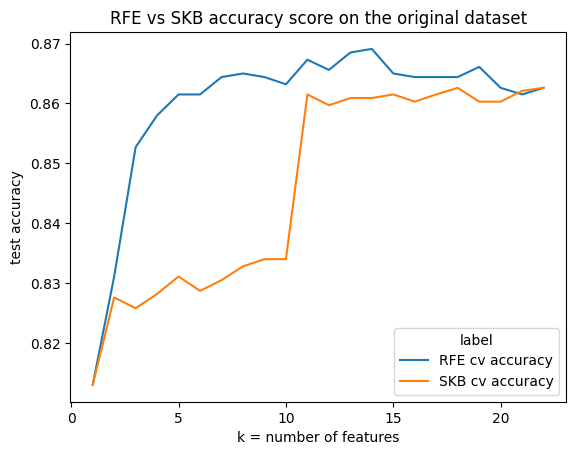

In [ ]:
results_skb_cv['label'] = "SKB cv accuracy" 
results_rfe_cv['label'] = "RFE cv accuracy"

results_all = pd.concat([results_rfe_cv, results_skb_cv])

sns.lineplot(data = results_all, x = "k", y = "score", hue="label")
plt.ylabel("test accuracy")
plt.xlabel("k = number of features")
plt.title("RFE vs SKB accuracy score on the original dataset")
plt.show()

## 039bis Identify common features

In [ ]:
features_rfe = set(results_rfe.loc[5,"features"])
features_rfe_extra = set(results_rfe.loc[11,"features"])
features_skb = set(results_skb.loc[11,"features"])

print("rfe, k=5 : ", features_rfe)
print("rfe, k=11 : ", features_rfe_extra)
print("skb, k=11 : ", features_skb)

rfe, k=5 :  {'offtrt', 'cd420', 'race', 'preanti', 'time'}
rfe, k=11 :  {'offtrt', 'cd420', 'race', 'preanti', 'age', 'drugs', 'z30', 'time', 'karnof', 'cd820', 'hemo'}
skb, k=11 :  {'offtrt', 'cd420', 'treat', 'preanti', 'cd40', 'z30', 'time', 'karnof', 'symptom', 'str2', 'strat'}


The following are the common features. They are important with respect to both methods.

In [ ]:
print(features_rfe.intersection(features_skb))
print(features_rfe_extra.intersection(features_skb))



{'offtrt', 'cd420', 'preanti', 'time'}
{'offtrt', 'cd420', 'preanti', 'z30', 'time', 'karnof'}


## 040bis Venn diagram for feature selection 

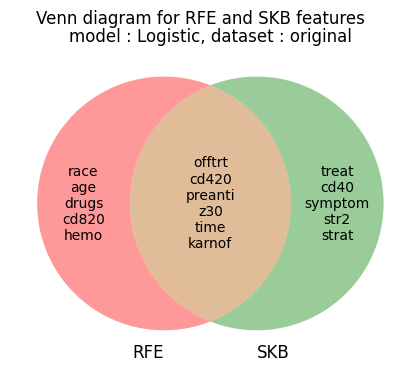

In [ ]:
# DIAGRAMMA DI VENN

set1 = features_rfe_extra
set2 = features_skb

# Crea il diagramma di Venn
plt.figure(figsize=(8, 4))
venn_diagram = venn2([set1, set2], ('RFE', 'SKB'))

# Assegna i nomi delle parole alle etichette nelle aree corrispondenti del diagramma di Venn
venn_diagram.get_label_by_id('10').set_text('\n'.join(set1 - set2))
venn_diagram.get_label_by_id('11').set_text('\n'.join(set1 & set2))
venn_diagram.get_label_by_id('01').set_text('\n'.join(set2 - set1))

# Mostra il grafico
plt.suptitle("Venn diagram for RFE and SKB features")
plt.title("model : Logistic, dataset : original")
plt.show()

## 041bis Argue Venn diagram insights

Very important features
- time : the time spent in treatment 
- cd420 : the number of CD T4 cells after 20 weeks of treatment 

Moderately important features 
- preanti : days spent in treatment before the study 
- z30 : if the patient was administered zidovudine prior to the study 

Features with probable important interactions
- karnof : the overall health status of the patient as measured by the karnof scale 
- offtrt : whether the patient went off-treatment within 96+-5 weeks (almost 2 years)






### Featuress selected in only SKB or only in RFE

Notable features selected in SKB:
- treat (probably interacting with other variables)
- cd40 (correlated with cd420)
- symptom (probably interacting with karnof)
- str2, strat (correlated with z30 and preanti)

Notable features selected in RFE:
- drugs, hemo, race (all slightly correlated with homo)
- cd820 indicating the status of infection after 20 weeks, probably important in rare cases
- age 



# Sprint 3


## 042 Data preprocessing and oversampling

### Load dataset

In [6]:
data = datasets.data_original()

### Feature engineering 

In [7]:
data = features.engineer(data)

### Train test split (unprocessed)

In [8]:
X_, y_ = data.drop('infected', axis=1), data['infected']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, random_state=42, stratify = y_)


### Oversampling train data 

In [9]:
# identify categorical features 
# The dataset does not have categorical features with more than 4 categories
cat_features = [c for c in X_train_.columns if X_train_[c].nunique() < 5]

In [10]:
smote_nc = SMOTENC(categorical_features=cat_features, sampling_strategy=1.0, random_state=42)
X_oversampled, y_oversampled = smote_nc.fit_resample(X_train_, y_train_) 

### Scaling the data 

In [11]:
scaler = StandardScaler()

X_train_scaled_oversampled = scaler.fit_transform(X_oversampled)
X_test_scaled = scaler.transform(X_test_)

### Data ready for Machine Learning

In [15]:
X_train =pd.DataFrame(X_train_scaled_oversampled,columns=X_.columns)
X_test =pd.DataFrame(X_test_scaled,columns=X_.columns)
y_train =y_oversampled 
y_test = y_test_ 

## 042-Sprint2 feature selection for oversampled data

### 042-027 Visualize oversampling impact 

### 042-029 Visualize train test split proportions

### 042-043 Cross-validation for RFE 

In [16]:
def rfe_kfold_cv(X, y, max_k=None, cv=5):
    if max_k is None:
        max_k = X.shape[1]
    
    results_rfe_kfold_cv = []
    for k in range(1, max_k + 1):
        
        rfe = RFE(estimator=LogisticRegression(solver="newton-cg",random_state=42), n_features_to_select=k)
        rfe.fit(X, y)
        selected_features = X.columns[rfe.support_]
        
        model = LogisticRegression(solver="newton-cg", random_state=42)
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X[selected_features], y, cv=skf, scoring='accuracy')
        
        results_rfe_kfold_cv.append({
            "k": k,
            "score": round(np.mean(cv_scores), 4),
            "features": list(selected_features)
        })
    
    return pd.DataFrame(results_rfe_kfold_cv).set_index('k')

In [17]:
results_rfe_kfold_cv = rfe_kfold_cv(X_train,y_train,cv=5)
results_df_kfold_cv = results_rfe_kfold_cv

rfe_best_k = results_df_kfold_cv['score'].idxmax()
rfe_best_accuracy = results_df_kfold_cv.loc[rfe_best_k, 'score']
rfe_best_features = results_df_kfold_cv.loc[rfe_best_k, 'features']

print(results_rfe_kfold_cv)
print(f"\noptimal number of features: {rfe_best_k} Accuracy: {rfe_best_accuracy:.2f}")

     score                                           features
k                                                            
1   0.8462                                          [time730]
2   0.8678                                  [offtrt, time730]
3   0.8829                           [offtrt, cd420, time730]
4   0.8895                     [race, offtrt, cd420, time730]
5   0.8902      [race, offtrt, cd420, time730, time_censored]
6   0.8953  [hemo, race, offtrt, cd420, time730, time_cens...
7   0.8984  [hemo, drugs, race, offtrt, cd420, time730, ti...
8   0.9015  [hemo, drugs, z30, race, offtrt, cd420, time73...
9   0.9042  [hemo, drugs, z30, race, gender, offtrt, cd420...
10  0.9049  [hemo, drugs, z30, race, gender, str2, offtrt,...
11  0.9049  [hemo, drugs, z30, preanti, race, gender, str2...
12  0.9045  [hemo, drugs, z30, preanti, race, gender, str2...
13  0.9038  [hemo, drugs, z30, preanti, race, gender, str2...
14  0.9080  [hemo, drugs, z30, preanti, race, gender, str2...
15  0.91

### 042-044 Cross-validation for SKB

In [18]:
def skb_kfold_cv(X, y, max_k=None, cv=5, score_func=f_classif):
    if max_k is None:
        max_k = X.shape[1]
    
    results_skb_kfold_cv = []
    for k in range(1, max_k + 1):
        
        skb = SelectKBest(score_func=score_func, k=k)
        skb.fit(X, y)
        selected_features = X.columns[skb.get_support()]
        
        model = LogisticRegression(solver="newton-cg", random_state=42)
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X[selected_features], y, cv=skf, scoring='accuracy')
        
        results_skb_kfold_cv.append({
            "k": k,
            "score": round(np.mean(cv_scores), 4),
            "features": list(selected_features)
        })
    
    return pd.DataFrame(results_skb_kfold_cv).set_index('k')

In [19]:
results_skb_kfold_cv = skb_kfold_cv(X_train,y_train,cv=5)
results_df_kfold_cv = results_skb_kfold_cv

skb_best_k = results_df_kfold_cv['score'].idxmax()
skb_best_accuracy = results_df_kfold_cv.loc[skb_best_k, 'score']
skb_best_features = results_df_kfold_cv.loc[skb_best_k, 'features']

print(results_skb_kfold_cv)
print(f"\noptimal number of features: {skb_best_k} Accuracy: {skb_best_accuracy:.2f}")

     score                                           features
k                                                            
1   0.8462                                          [time730]
2   0.8508                           [time730, time_censored]
3   0.8628                    [cd420, time730, time_censored]
4   0.8632              [cd420, time730, time_censored, trt1]
5   0.8640        [cd40, cd420, time730, time_censored, trt1]
6   0.8779  [race, cd40, cd420, time730, time_censored, trt1]
7   0.8806  [homo, race, cd40, cd420, time730, time_censor...
8   0.8841  [homo, race, cd40, cd420, time730, time_censor...
9   0.8875  [homo, drugs, race, cd40, cd420, time730, time...
10  0.8868  [homo, drugs, race, gender, cd40, cd420, time7...
11  0.8879  [hemo, homo, drugs, race, gender, cd40, cd420,...
12  0.8864  [hemo, homo, drugs, race, gender, cd40, cd420,...
13  0.8910  [hemo, homo, drugs, z30, race, gender, cd40, c...
14  0.8895  [hemo, homo, drugs, z30, preanti, race, gender...
15  0.88

### 042-045 Visualize Cross-validation scores 

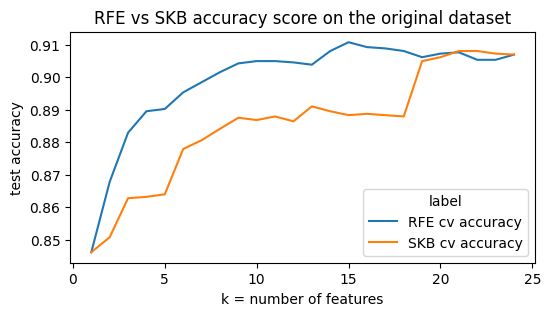

In [20]:
results_skb_kfold_cv['label'] = "SKB cv accuracy" 
results_rfe_kfold_cv['label'] = "RFE cv accuracy"

results_all = pd.concat([results_rfe_kfold_cv, results_skb_kfold_cv])

sns.lineplot(data = results_all, x = "k", y = "score", hue="label")
plt.ylabel("test accuracy")
plt.xlabel("k = number of features")
plt.title("RFE vs SKB accuracy score on the original dataset")
plt.show()

### Insights on features selected by RFE and SKB

In the accuracy graph of the SKB algorithm we notice important jumps from $k=2$ to $k=3$, from $k=5$ to $k =6$ and from $k=18$ to $k=19$.

In [21]:
results = results_skb_kfold_cv

for k in [2,5,18]:
    features1 = results.loc[k,"features"]
    features2 = results.loc[k+1,"features"]
    new_feature = set(features2) - set(features1)
    print(f"From k = {k} to k={k+1} the model learned to use the feature: {new_feature}")


From k = 2 to k=3 the model learned to use the feature: {'cd420'}
From k = 5 to k=6 the model learned to use the feature: {'race'}
From k = 18 to k=19 the model learned to use the feature: {'offtrt'}


### 042-034-037 Select k for RFE and SKB

In [22]:
rfe_selected_features=results_rfe_kfold_cv.loc[8,"features"]    
skb_selected_features=results_skb_kfold_cv.loc[6,"features"]
print(f"selected features for rfe:8",rfe_selected_features) 
print(f"\nselected features for skb:6",skb_selected_features)    

selected features for rfe:8 ['hemo', 'drugs', 'z30', 'race', 'offtrt', 'cd420', 'time730', 'time_censored']

selected features for skb:6 ['race', 'cd40', 'cd420', 'time730', 'time_censored', 'trt1']


### 042-039-040 Venn diagram for common features

## 046 Choose best models 

Here we choose the best models selected with both the RFE and SKB algorithms.

In [23]:
k_rfe = 8
rfe_selected_features=results_rfe_kfold_cv.loc[k_rfe,"features"]

# from 6 to 7 there is not much improvemente
k_skb = 6
skb_selected_features=results_skb_kfold_cv.loc[k_skb,"features"]

print(f"selected features for rfe:",k_rfe, rfe_selected_features) 
print(f"\nselected features for skb:",k_skb, skb_selected_features) 

selected features for rfe: 8 ['hemo', 'drugs', 'z30', 'race', 'offtrt', 'cd420', 'time730', 'time_censored']

selected features for skb: 6 ['race', 'cd40', 'cd420', 'time730', 'time_censored', 'trt1']


Now we fit the best models

In [24]:
model_rfe = LogisticRegression(random_state=42) 
X_rfe_train = X_train[rfe_selected_features]
X_rfe_test = X_test[rfe_selected_features]
model_rfe.fit(X_rfe_train,y_train)

LogisticRegression(random_state=42)

In [25]:
model_skb = LogisticRegression(random_state=42) 
X_skb_train = X_train[skb_selected_features]
X_skb_test = X_test[skb_selected_features]
model_skb.fit(X_skb_train,y_train)

LogisticRegression(random_state=42)

## 047 Discuss model performance

In [26]:
from sklearn.model_selection import cross_validate 
def cv_mean_scores(Xtrain, ytrain, model = LogisticRegression(random_state=42), n_splits  = 5):
    # Create the K-Fold cross-validator
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
     
    # Choose the scores to be computed
    selectivity_score = make_scorer(recall_score, pos_label = 0)
    negative_predictive_value = make_scorer(precision_score, pos_label = 0)


    my_scores= {
        "accuracy": "accuracy",
        "recall": "recall",   # true positive rate
        "selectivity": selectivity_score,   # true negative rate
        "precision": "precision",  # positive predictive value 
        "NPV": negative_predictive_value, # negative predictive value,
        "f1": "f1",
        "ROC_AUC": "roc_auc"
    }

    # Perform cross-validation measuring the scores
    cv_results = cross_validate(
        model, Xtrain, ytrain, cv=cv, n_jobs=-1, scoring= my_scores
    )


    # Calculate the mean of each score
    mean_scores =  {score : cv_results["test_"+score].mean() for score in my_scores}
    return mean_scores

We evaluate the best SKB model

In [27]:
best_skb_cv_scores = cv_mean_scores(X_skb_train,y_train)
for score in best_skb_cv_scores:
    print(score, ":", f"{best_skb_cv_scores[score]:.3f}") 

accuracy : 0.878
recall : 0.910
selectivity : 0.847
precision : 0.857
NPV : 0.904
f1 : 0.882
ROC_AUC : 0.933


In [28]:
best_rfe_cv_scores = cv_mean_scores(X_rfe_train,y_train)
for score in best_rfe_cv_scores:
    print(score, ":", f"{best_rfe_cv_scores[score]:.3f}") 

accuracy : 0.901
recall : 0.918
selectivity : 0.885
precision : 0.889
NPV : 0.915
f1 : 0.903
ROC_AUC : 0.961


The model has no obvious weaknesses and it is very good on Recall (true positive rate), which is actually what we care about the most. 
In cross-validation, if a patient is truly "infected" then the model classifies the patient correctly 92% of the times, on cv_average. 

**Caveat** We are doing cross validation on a train set in which the target class "infected" has been oversampled. For this reason the score "Recall" may be too optimistic.

## 048 Interpret model coefficients 

In [29]:
# model intercept:

intercept_rfe = model_rfe.intercept_[0]
intercept_skb = model_skb.intercept_[0]


print(f"The intercept of the best SKB model is equal to {intercept_skb:.4f}")
print(f"The intercept of the best RFE model is equal to {intercept_rfe:.4f}")

The intercept of the best SKB model is equal to -0.3297
The intercept of the best RFE model is equal to -0.2041


The intercept is negative. It means that an average patient is evaluated by the models with a bias. This bias is towards the "non-infected" class. 

In [30]:
# we calculate the model coefficients for each feature 

coefficients_skb = pd.DataFrame({
    "feature": skb_selected_features,
    "coefficient": model_skb.coef_[0]
})

coefficients_rfe = pd.DataFrame({
    "feature": rfe_selected_features,
    "coefficient": model_rfe.coef_[0]
})

coefficients_rfe.sort_values(by="coefficient", inplace=True)
coefficients_skb.sort_values(by="coefficient", inplace=True)


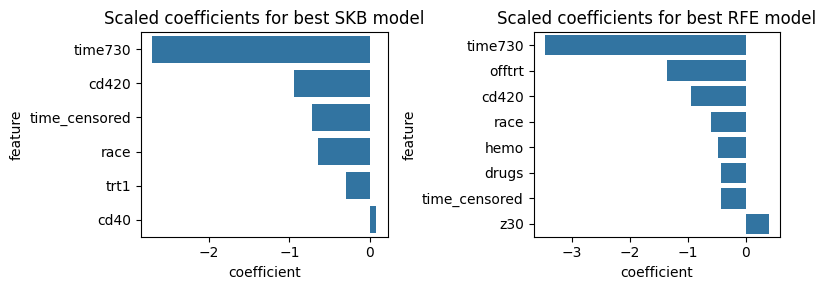

In [31]:
fig, axes = plt.subplots(1,2, figsize = (8,3))

sns.barplot(data = coefficients_skb, y = "feature", x = "coefficient", ax = axes[0])
sns.barplot(data = coefficients_rfe, y = "feature", x = "coefficient", ax = axes[1])

axes[0].set_title("Scaled coefficients for best SKB model")
axes[1].set_title("Scaled coefficients for best RFE model")

plt.tight_layout()
plt.show()

## 049 Render coefficients insights 

### 049-a Obtain coefficients for the unscaled variables

The coefficients found in 048 are relative to the features scaled with StandardScaler. They are therefore hard to interpret as they are. 
We now calculate the coefficients one gets for the un-scaled regressors. 

In [38]:
# for each variable we calculate the rate of scaling 
scaling_factors = pd.DataFrame({
    "feature": X_.columns,
    "scaling_factor": scaler.scale_
})
scaling_factors.head(3)

,feature,scaling_factor
0,age,8.371537
1,wtkg,12.215701
2,hemo,0.226967


In [42]:
# we merge with model coefficients 
coefficients_and_scaling_skb = coefficients_skb.merge(scaling_factors)
coefficients_and_scaling_rfe = coefficients_rfe.merge(scaling_factors)

# calculate un-scaled coefficient
coefficients_and_scaling_skb["coefficient_unscaled"] = coefficients_and_scaling_skb["coefficient"] / coefficients_and_scaling_skb["scaling_factor"]
coefficients_and_scaling_rfe["coefficient_unscaled"] = coefficients_and_scaling_rfe["coefficient"] / coefficients_and_scaling_rfe["scaling_factor"]

# order and print the results
coefficients_and_scaling_skb.sort_values(by="coefficient", ascending=False, inplace=True)
coefficients_and_scaling_rfe.sort_values(by="coefficient", ascending=False, inplace=True)

print("Feature coefficients of the model selected by SKB:")
print(coefficients_and_scaling_skb)
print()
print("Feature coefficients of the model selected by RFE:")
print(coefficients_and_scaling_skb)



Feature coefficients of the model selected by SKB:
         feature  coefficient  scaling_factor  coefficient_unscaled
5           cd40     0.083263      113.433634              0.000734
4           trt1    -0.294426        0.378339             -0.778205
3           race    -0.638489        0.411245             -1.552575
2  time_censored    -0.722956      176.804851             -0.004089
1          cd420    -0.942691      141.028766             -0.006684
0        time730    -2.706186      161.366770             -0.016770

Feature coefficients of the model selected by RFE:
         feature  coefficient  scaling_factor  coefficient_unscaled
5           cd40     0.083263      113.433634              0.000734
4           trt1    -0.294426        0.378339             -0.778205
3           race    -0.638489        0.411245             -1.552575
2  time_censored    -0.722956      176.804851             -0.004089
1          cd420    -0.942691      141.028766             -0.006684
0        time

### Visualize coefficients of unscaled variables

In [ ]:
coefficients_unscaled = coefficients_and_scaling.drop(columns = ['coefficient', 'scaling_factor'])

# To better understand and compare the variables and coefficients
# we further custom-rescale the continuous variables.

# - time730, time_censored, preanti: unit = month (scale 30)
for i in [11,12,4]:
    row = dict(coefficients_unscaled.loc[i])
    row['feature'] = row['feature'] + " (months)"
    row['coefficient_unscaled'] = row['coefficient_unscaled'] * 30
    coefficients_unscaled.loc[i] = row

# - cd80, cd420: hundreds (scale 100)
for i in [9,10]:
    row = dict(coefficients_unscaled.loc[i])
    row['feature'] = row['feature'] + " (x100)"
    row['coefficient_unscaled'] = row['coefficient_unscaled'] * 100
    coefficients_unscaled.loc[i] = row

# - age: tenths (scale 100)
for i in [0]:
    row = dict(coefficients_unscaled.loc[i])
    row['feature'] = row['feature'] + " (x10)"
    row['coefficient_unscaled'] = row['coefficient_unscaled'] * 10
    coefficients_unscaled.loc[i] = row
coefficients_unscaled

,feature,coefficient_unscaled
3,z30,1.142343
6,gender,0.932941
4,preanti (months),0.014944
10,cd80 (x100),0.042235
0,age (x10),0.205526
14,trt2,-0.644231
7,str2,-0.560421
13,trt1,-0.825895
2,drugs,-1.372303
1,hemo,-2.014646


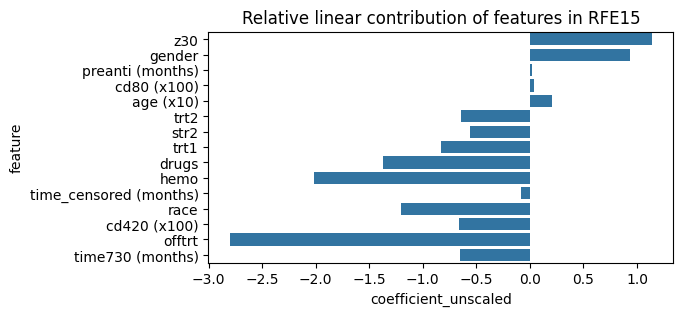

In [ ]:
sns.barplot(data = coefficients_unscaled, x ="coefficient_unscaled", y = "feature")
plt.title("Relative linear contribution of features in RFE15")
plt.show()

## 050 Test set performance 

In [ ]:
y_pred = model_rfe.predict(X_rfe_test)

In [ ]:
results_test = {
    "accuracy": accuracy_score(y_test,y_pred),
    "recall": recall_score(y_test,y_pred),
    "selectivity": recall_score(y_test,y_pred,pos_label = 0),
    "precision": precision_score(y_test,y_pred),
    "NPV": precision_score(y_test,y_pred, pos_label = 0),
    "f1": f1_score(y_test,y_pred)
}

results_test

{'accuracy': 0.897196261682243,
 'recall': np.float64(0.8076923076923077),
 'selectivity': np.float64(0.9259259259259259),
 'precision': np.float64(0.7777777777777778),
 'NPV': np.float64(0.9375),
 'f1': np.float64(0.7924528301886793)}

The recall score has dropped. The reason is clear: in cross-validation we used over-sampling. It would be better to oversample as part of the model. 

## 051 Confusion matrix 


In [ ]:
cm  = confusion_matrix(y_test,y_pred)
cm

array([[300,  24],
       [ 20,  84]])

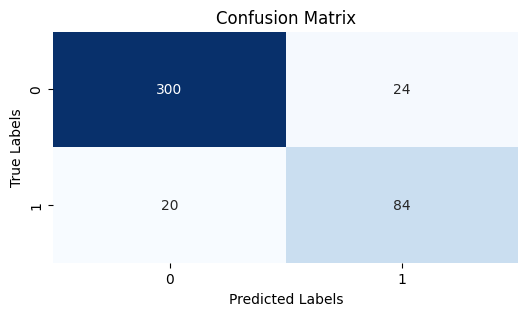

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()